# Preparation of dataset for Elemental Descriptor

In [1]:
import tpot
import sys
import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf
import platform
import pandas as pd
import matplotlib.pyplot as plt
import chemparse
from matplotlib.patches import Rectangle
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import LeaveOneOut
import numpy as np
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error
from sklearn.svm import SVR
import matplotlib
from sklearn.decomposition import PCA
import pandas as pd
import chemparse
import os

print(f"Python Platform: {platform.platform()}")
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Python Platform: macOS-12.6-arm64-arm-64bit
Tensor Flow Version: 2.10.0
Keras Version: 2.10.0

Python 3.9.15 | packaged by conda-forge | (main, Nov 22 2022, 08:48:25) 
[Clang 14.0.6 ]
Pandas 1.4.2
Scikit-Learn 1.0.2
GPU is available


# Analysis of the descriptor

In [2]:
descriptor = pd.read_csv(r'output.csv', header = None, sep = "\s+|\t+|\s+\t+|\t+\s+", engine='python')
desc_only = descriptor.iloc[:, 1:-1] ## properties_A, X_A, properties_B, X_B (16 each), where X_A weighted are properties of elements

# original order in the output.csv file:
#                A1       B1      A1/B1             A1*B1     
# ionic radii   1.035  0.8525 1.2140762463343107  0.8823375 
# idbond         2.2     2.0      1.1                4.4
# electronegativity 2.02 1.83 1.1038251366120218 3.6966
# vwd            2.07 2.04 1.0147058823529411 4.222799999999999
# ion E          7.285516 17.9024681 0.9219291881735024 57.5735577820396
# molar V          21.31 7.09        3.005641748942172 151.0879
# atomic number    83.0 26.0 3.1923076923076925 2158.0
# atomic mass    208.9804  55.845 3.742150595397977 11670.510438 

In [152]:
descriptor.iloc[:, 0:1]

,0
0,(Bi100.0)(Ca100.0)(Fe100.0)()X3
1,(Bi95.0)(Ca5.0)(Fe100.0)()X3
2,(Bi90.0)(Ca10.0)(Fe100.0)()X3
3,(Bi85.0)(Ca15.0)(Fe100.0)()X3
4,(Bi80.0)(Ca20.0)(Fe100.0)()X3
...,...
80,(Ca200.0)()(Fe100.0)(Bi100.0)X3
81,(Ca200.0)()(Sm100.0)(Bi100.0)X3
82,(Ca200.0)()(Dy100.0)(Bi100.0)X3
83,(Ca200.0)()(Fe100.0)(Bi100.0)X3


Text(0.5, 1.0, '        A1     A2    B1     B2    A1/B1 A2/B2 A1*B1 A2*B2')

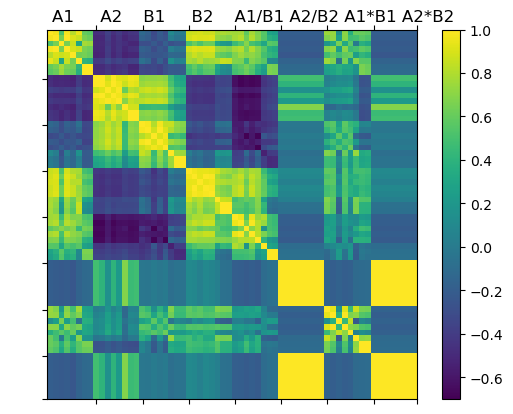

In [3]:
# Just for visualization - legacy code
# rearranged into: A1   A2    B1  B2  A1/B1   A2/B2  A1*B1  A2*B2
desc_only_rearranged = desc_only[[1,  5,  9, 13, 17, 21, 25, 29, 33, 37, 41, 45, 49, 53, 57, 61, #A1 A2
                                  2,  6, 10, 14, 18, 22, 26, 30, 34, 38, 42, 46, 50, 54, 58, 62, #B1 B2
                                  3,  7, 11, 15, 19, 23, 27, 31, 35, 39, 43, 47, 51, 55, 59, 63, # A1/B1 A2/B2
                                  4,  8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64]] # A1*B1 A2*B2

figure = plt.figure()
axes = figure.add_subplot(111)

caxes = axes.matshow(desc_only_rearranged.corr())
figure.colorbar(caxes)

ticks = [8, 16, 24, 32, 40, 48, 56, 63.5]
axes.set_xticks(ticks)
axes.set_yticks(ticks)
axes.set_xticklabels(['' , '' , '' , '' , '' , '' , '' , '' , ])
axes.set_yticklabels(['' , '' , '' , '' , '' , '' , '' , '' , ])
axes.set_title('        A1     A2    B1     B2    A1/B1 A2/B2 A1*B1 A2*B2')

In [4]:
# naming the columns in the desc_only dataframe
counter = 0

for properties in ("'ionic_radii_", "'ideal_X-O_bond_", "'electronegativity_", "'vdW_radius_",
                   "'ionization_E_", "'Molar_V_", "'Atomic_#_", "'Atomic_mass_"):
    for site in ('A1', 'B1', 'A1/B1', 'A1*B1'):
        counter = counter + 1
#        print (str(counter)+': '+properties+site+"',")
    
for properties in ("'ionic_radii_", "'ideal_X-O_bond_", "'electronegativity_", "'vdW_radius_",
                   "'ionization_E_", "'Molar_V_", "'Atomic_#_", "'Atomic_mass_"):
    for site in ('A2', 'B2', 'A2/B2', 'A2*B2'):
        counter = counter + 1
#        print (str(counter)+': '+properties+site+"',")

In [5]:
desc_only_named = desc_only.rename({
1: 'ionic_radii_A1', 2: 'ionic_radii_B1',  3: 'ionic_radii_A1/B1',  4: 'ionic_radii_A1*B1', 5: 'ideal_X-O_bond_A1',
6: 'ideal_X-O_bond_B1', 7: 'ideal_X-O_bond_A1/B1',  8: 'ideal_X-O_bond_A1*B1',  9: 'electronegativity_A1',
10: 'electronegativity_B1', 11: 'electronegativity_A1/B1', 12: 'electronegativity_A1*B1',
13: 'vdW_radius_A1', 14: 'vdW_radius_B1', 15: 'vdW_radius_A1/B1', 16: 'vdW_radius_A1*B1',
17: 'ionization_E_A1', 18: 'ionization_E_B1', 19: 'ionization_E_A1/B1', 20: 'ionization_E_A1*B1',
21: 'Molar_V_A1', 22: 'Molar_V_B1', 23: 'Molar_V_A1/B1', 24: 'Molar_V_A1*B1', 25: 'Atomic_#_A1', 26: 'Atomic_#_B1',
27: 'Atomic_#_A1/B1', 28: 'Atomic_#_A1*B1', 29: 'Atomic_mass_A1',  30: 'Atomic_mass_B1', 31: 'Atomic_mass_A1/B1',
32: 'Atomic_mass_A1*B1', 33: 'ionic_radii_A2',  34: 'ionic_radii_B2', 35: 'ionic_radii_A2/B2', 36: 'ionic_radii_A2*B2',
37: 'ideal_X-O_bond_A2', 38: 'ideal_X-O_bond_B2', 39: 'ideal_X-O_bond_A2/B2', 40: 'ideal_X-O_bond_A2*B2', 41: 'electronegativity_A2',
42: 'electronegativity_B2', 43: 'electronegativity_A2/B2', 44: 'electronegativity_A2*B2', 45: 'vdW_radius_A2',
46: 'vdW_radius_B2',  47: 'vdW_radius_A2/B2', 48: 'vdW_radius_A2*B2', 49: 'ionization_E_A2', 50: 'ionization_E_B2',
51: 'ionization_E_A2/B2',  52: 'ionization_E_A2*B2', 53: 'Molar_V_A2',  54: 'Molar_V_B2', 55: 'Molar_V_A2/B2',
56: 'Molar_V_A2*B2', 57: 'Atomic_#_A2',  58: 'Atomic_#_B2', 59: 'Atomic_#_A2/B2', 60: 'Atomic_#_A2*B2', 61: 'Atomic_mass_A2',
62: 'Atomic_mass_B2', 63: 'Atomic_mass_A2/B2', 64: 'Atomic_mass_A2*B2',
}, axis=1)

desc_only_named # named dataframe

,ionic_radii_A1,ionic_radii_B1,ionic_radii_A1/B1,ionic_radii_A1*B1,ideal_X-O_bond_A1,ideal_X-O_bond_B1,ideal_X-O_bond_A1/B1,ideal_X-O_bond_A1*B1,electronegativity_A1,electronegativity_B1,...,Molar_V_A2/B2,Molar_V_A2*B2,Atomic_#_A2,Atomic_#_B2,Atomic_#_A2/B2,Atomic_#_A2*B2,Atomic_mass_A2,Atomic_mass_B2,Atomic_mass_A2/B2,Atomic_mass_A2*B2
0,1.03500,0.8525,1.214076,0.882337,2.20,2.00,1.100000,4.40,2.020,1.83,...,0.0,0.0,20.0,0.0,0.0,0.0,40.0780,0.0000,0.0,0.0
1,0.98325,0.8525,1.153372,0.838221,2.09,2.00,1.045000,4.18,1.919,1.83,...,0.0,0.0,1.0,0.0,0.0,0.0,2.0039,0.0000,0.0,0.0
2,0.93150,0.8525,1.092669,0.794104,1.98,2.00,0.990000,3.96,1.818,1.83,...,0.0,0.0,2.0,0.0,0.0,0.0,4.0078,0.0000,0.0,0.0
3,0.87975,0.8525,1.031965,0.749987,1.87,2.00,0.935000,3.74,1.717,1.83,...,0.0,0.0,3.0,0.0,0.0,0.0,6.0117,0.0000,0.0,0.0
4,0.82800,0.8525,0.971261,0.705870,1.76,2.00,0.880000,3.52,1.616,1.83,...,0.0,0.0,4.0,0.0,0.0,0.0,8.0156,0.0000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,2.28000,0.8525,2.674487,1.943700,4.80,2.00,2.400000,9.60,2.000,1.83,...,0.0,0.0,0.0,83.0,0.0,0.0,0.0000,208.9804,0.0,0.0
81,2.28000,1.2290,1.855167,2.802120,4.80,2.45,1.959184,11.76,2.000,1.17,...,0.0,0.0,0.0,83.0,0.0,0.0,0.0000,208.9804,0.0,0.0
82,2.28000,1.1310,2.015915,2.578680,4.80,2.35,2.042553,11.28,2.000,1.22,...,0.0,0.0,0.0,83.0,0.0,0.0,0.0000,208.9804,0.0,0.0
83,2.28000,0.8525,2.674487,1.943700,4.80,2.00,2.400000,9.60,2.000,1.83,...,0.0,0.0,0.0,83.0,0.0,0.0,0.0000,208.9804,0.0,0.0


In [6]:
# Visual check that the first compund is right:
#                A1       B1      A1/B1             A1*B1     
# ionic radii   1.035  0.8525 1.2140762463343107  0.8823375 
# idbond         2.2     2.0      1.1                4.4
# electronegativity 2.02 1.83 1.1038251366120218 3.6966
# vwd            2.07 2.04 1.0147058823529411 4.222799999999999
# ion E          7.285516 17.9024681 0.9219291881735024 57.5735577820396
# molar V          21.31 7.09        3.005641748942172 151.0879
# atomic number    83.0 26.0 3.1923076923076925 2158.0
# atomic mass    208.9804  55.845 3.742150595397977 11670.510438 

[Text(0, 7.5, ''),
 Text(0, 15.5, ''),
 Text(0, 23.5, ''),
 Text(0, 31.5, ''),
 Text(0, 39.5, ''),
 Text(0, 47.5, ''),
 Text(0, 55.5, ''),
 Text(0, 63.5, '')]

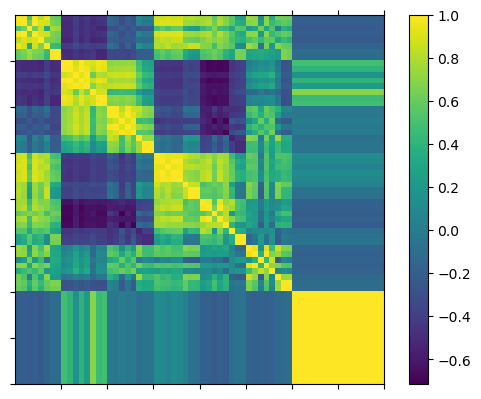

In [7]:
# delete A2/B2 and A2*B2
# graph = desc_only_named.loc[:,~desc_only_named.columns.str.endswith('A2/B2')]
# graph_withoutA2B2_comb = graph.loc[:,~graph.columns.str.endswith('A2*B2')]

# reorder the columns:
one = desc_only_named.loc[:, desc_only_named.columns.str.endswith('_A1')]
two = desc_only_named.loc[:, desc_only_named.columns.str.endswith('_A2')]
three = desc_only_named.loc[:, desc_only_named.columns.str.endswith('_B1')]
four = desc_only_named.loc[:, desc_only_named.columns.str.endswith('_B2')]
five = desc_only_named.loc[:, desc_only_named.columns.str.endswith('_A1/B1')]
six = desc_only_named.loc[:, desc_only_named.columns.str.endswith('_A1*B1')]
seven = desc_only_named.loc[:, desc_only_named.columns.str.endswith('_A2/B2')]
eight = desc_only_named.loc[:, desc_only_named.columns.str.endswith('_A2*B2')]

desc_only_A1A2B1B2A1B1A2B2 = pd.concat([one, two, three, four, five, six, seven, eight], axis=1)


# visualize the correlations of the columns:
figure = plt.figure()
axes = figure.add_subplot(111)

#caxes = axes.matshow(matrix_plt[~desc_only_A1A2B1B2divProd.duplicated()].corr())
caxes = axes.matshow(desc_only_A1A2B1B2A1B1A2B2[~desc_only_A1A2B1B2A1B1A2B2.duplicated()].corr())
figure.colorbar(caxes)

ticks = [7.5, 15.5, 23.5, 31.5, 39.5, 47.5, 55.5, 63.5]
axes.set_xticks(ticks)
axes.set_yticks(ticks)
axes.set_xticklabels(['' , '' , '' , '' , '' , '', '' , ''])
axes.set_yticklabels(['' , '' , '' , '' , '' , '', '' , ''])

In [8]:
desc_only_A1A2B1B2A1B1A2B2 # it is the same as desc_only_rearranged just named, 64 columns

,ionic_radii_A1,ideal_X-O_bond_A1,electronegativity_A1,vdW_radius_A1,ionization_E_A1,Molar_V_A1,Atomic_#_A1,Atomic_mass_A1,ionic_radii_A2,ideal_X-O_bond_A2,...,Atomic_#_A2/B2,Atomic_mass_A2/B2,ionic_radii_A2*B2,ideal_X-O_bond_A2*B2,electronegativity_A2*B2,vdW_radius_A2*B2,ionization_E_A2*B2,Molar_V_A2*B2,Atomic_#_A2*B2,Atomic_mass_A2*B2
0,1.03500,2.20,2.020,2.0700,7.285516,21.3100,83.00,208.98040,1.140,2.40,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.98325,2.09,1.919,1.9665,6.921240,20.2445,78.85,198.53138,0.057,0.12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.93150,1.98,1.818,1.8630,6.556964,19.1790,74.70,188.08236,0.114,0.24,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.87975,1.87,1.717,1.7595,6.192689,18.1135,70.55,177.63334,0.171,0.36,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.82800,1.76,1.616,1.6560,5.828413,17.0480,66.40,167.18432,0.228,0.48,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,2.28000,4.80,2.000,4.6200,12.226311,52.4000,40.00,80.15600,0.000,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
81,2.28000,4.80,2.000,4.6200,12.226311,52.4000,40.00,80.15600,0.000,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
82,2.28000,4.80,2.000,4.6200,12.226311,52.4000,40.00,80.15600,0.000,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
83,2.28000,4.80,2.000,4.6200,12.226311,52.4000,40.00,80.15600,0.000,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Simple correlation matrix plot for A1 features:

In [9]:
#pd.plotting.scatter_matrix(desc_only.iloc[:, [0, 4, 8, 12, 16, 20, 24, 28]], alpha=0.2, figsize=(8, 8))

Histograms showing the zero features:

array([[<AxesSubplot: title={'center': '1'}>,
        <AxesSubplot: title={'center': '2'}>,
        <AxesSubplot: title={'center': '3'}>,
        <AxesSubplot: title={'center': '4'}>],
       [<AxesSubplot: title={'center': '5'}>,
        <AxesSubplot: title={'center': '6'}>,
        <AxesSubplot: title={'center': '7'}>,
        <AxesSubplot: title={'center': '8'}>],
       [<AxesSubplot: title={'center': '9'}>,
        <AxesSubplot: title={'center': '10'}>,
        <AxesSubplot: title={'center': '11'}>,
        <AxesSubplot: title={'center': '12'}>],
       [<AxesSubplot: title={'center': '13'}>,
        <AxesSubplot: title={'center': '14'}>,
        <AxesSubplot: title={'center': '15'}>,
        <AxesSubplot: title={'center': '16'}>],
       [<AxesSubplot: title={'center': '17'}>,
        <AxesSubplot: title={'center': '18'}>,
        <AxesSubplot: title={'center': '19'}>,
        <AxesSubplot: title={'center': '20'}>],
       [<AxesSubplot: title={'center': '21'}>,
        <AxesSubp

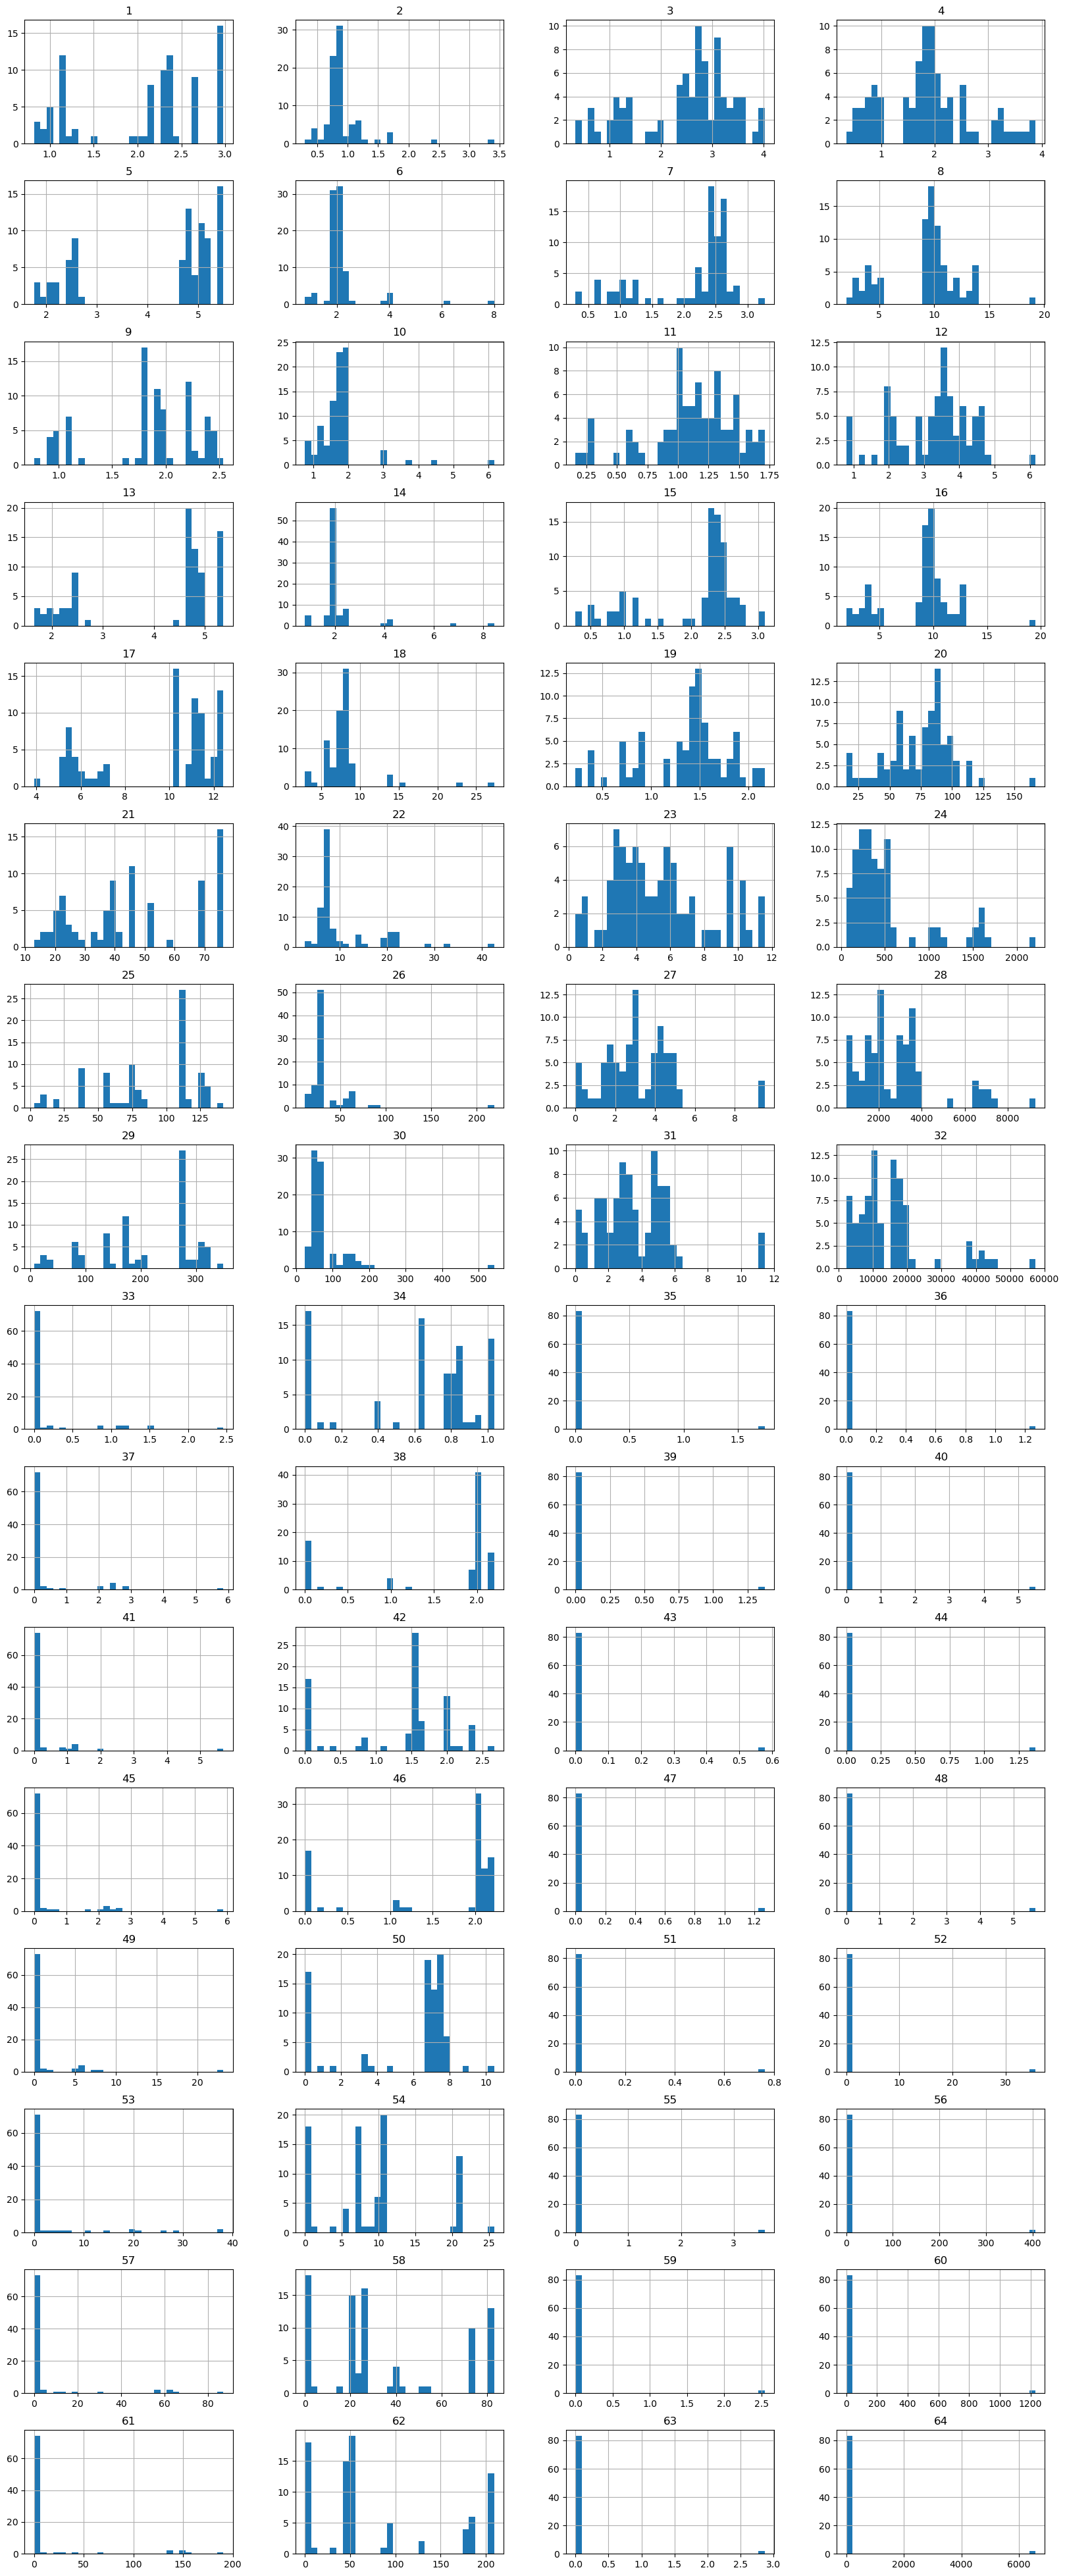

In [35]:
desc_only.hist(figsize = (20, 50), layout = (16, 4), bins=30)

Reading of elemental weight composition:

In [11]:
df = pd.read_excel(r'/Users/hostas/Documents/01-Analysis/2022-11-06 Perovskites/perovskites.xlsx')

cleaned = pd.DataFrame()
cleaned['Chemical Formula']=df['Chemical Formula']
cleaned['Chemical Formula Dictionary']=df['Chemical Formula']
lenght=len(cleaned['Chemical Formula'])

for row in range(lenght):
    cleaned['Chemical Formula Dictionary'][row]= chemparse.parse_formula(cleaned['Chemical Formula'][row])
    
matrix = cleaned['Chemical Formula Dictionary'].apply(pd.Series)
matrix['sum'] = matrix.sum(axis = 1)
wlenght=len(matrix.columns)

for col in range(wlenght):
    matrix.iloc[:, col] = matrix.iloc[:, col] / matrix['sum']
        
compositions = matrix.drop(columns='sum').fillna(0)
non_weight_compositions = compositions.copy()
# non_weight_compositions

#Data for elemental weights, source: https://www.angelo.edu/faculty/kboudrea/periodic/structure_mass.htm
elements = ['O', 'La', 'Ba', 'Fe', 'Bi', 'Sr', 'Ti', 'Mn', 'Ca', 'Ni', 'Gd', 'Co', 'Dy', 'Ta', 'Nb', 'W', 'Zn', 'Eu', 'Pr', 'Sm', 'Mg', 'Cr', 'Na', 'In', 'Cu', 'Lu', 'Tb', 'Y', 'Te', 'Ga', 'Nd', 'Ag', 'Ce', 'V', 'I', 'Mo', 'Sc', 'Al', 'Li']
weights = [15.9994, 138.9055, 137.33, 55.847, 208.9804, 87.62, 47.90, 54.9380, 40.08, 58.70, 157.25, 58.9332, 162.50, 180.9479, 92.9064, 183.85, 65.38, 151.96, 140.9077, 150.4, 24.305, 51.996, 22.98977, 114.82, 63.546, 174.967, 158.9254, 88.9059, 127.60, 69.72, 144.24, 107.868, 140.12, 50.9415, 126.9045, 95.94, 44.9559, 26.98154, 6.941]

elemental_weight = dict(zip(elements, weights))

# Change to weight composition
counter = -1

for col in compositions.columns:
    counter+=1
    element = col
    compositions.iloc[:, counter] = compositions.iloc[:, counter] * elemental_weight[col]

lenght=len(compositions['Bi'])

compositions['sum'] = compositions.sum(axis = 1)
wlenght=len(compositions.columns)

for col in range(wlenght):
    compositions.iloc[:, col] = compositions.iloc[:, col] / compositions['sum']
        
weight_compositions = compositions.drop(columns='sum')


weight_compositions_NaN = weight_compositions.copy()
weight_compositions_NaN['Bandgap'] = df.iloc[:, 21]
weight_compositions_NaN = weight_compositions_NaN.dropna()


non_zero_weights = weight_compositions[weight_compositions > 0].count().sort_values(ascending=False)#.iloc[0:11]

del[[matrix, counter, cleaned, elements, weights]]
# compositions
# weight_compositions
# weight_compositions_NaN
# elemental_weight
# non_zero_weights

In [219]:
compositions.iloc[0:1, :]

,Bi,Ca,Fe,O,Gd,Cr,Sr,Ta,Ni,Mo,...,V,Ce,Nd,In,Te,Ga,Tb,Y,Al,sum
0,0.592171,0.113571,0.158249,0.136009,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [220]:
weight_compositions.iloc[0:1, :]

,Bi,Ca,Fe,O,Gd,Cr,Sr,Ta,Ni,Mo,...,Pr,V,Ce,Nd,In,Te,Ga,Tb,Y,Al
0,0.592171,0.113571,0.158249,0.136009,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [225]:
mass_test = 208.9804/2+40.08/2+55.847+15.9994*3
mass_test

228.3754

In [228]:
208.9804/2/mass_test # bi

0.4575370201869378

In [235]:
# [         Bi,       Ca,       Fe,           O,          Gd,  ...]
# [   208.9804,    40.08,   55.847,     15.9994,      157.25, … ]

208.9804/2/(208.9804/2+40.08/2+55.847+15.9994*3) # bi 0.4575370201869378

0.4575370201869378

In [232]:
40.08/2/(208.9804/2+40.08/2+55.847+15.9994*3) # Ca 0.0877502568140001

0.0877502568140001

In [233]:
55.847/(208.9804/2+40.08/2+55.847+15.9994*3) # Fe 0.2445403489167397

0.2445403489167397

In [234]:
15.9994*3/(208.9804/2+40.08/2+55.847+15.9994*3) # O 0.21017237408232234

0.21017237408232234

Just a test with Iron that the reading of bandgap/weight compositions work:

In [12]:
# element=['Fe']; color=['orange']
# plt.hist(weight_compositions[element], color=color, edgecolor='black', bins=int(10/1))
# plt.xlabel('Composition / wt.%'); plt.ylabel('No. compounds')
# plt.title(str(non_zero_weights[element][0])+' compounds with '+str(element[0]))
# plt.ylim([0, 80])
# cmap = plt.get_cmap('jet'); low = cmap(0.5)
# handles = [Rectangle((0,0),1,1, color=color[0], ec="k") for c in element]; labels= element
# plt.legend(handles, labels)

Including Crystal system and Sample prep:

In [13]:
encoder = OneHotEncoder(handle_unknown='ignore'); additional = pd.DataFrame()

additional['Crystal system'] = df['Crystal system'].str.lower().str.strip()
additional['Sample preparation'] = df['Sample preparation'].str.lower().str.strip() # additional['Sample preparation'].unique()
newones = pd.get_dummies(additional['Crystal system'])
newones2 = pd.get_dummies(additional['Sample preparation'])
crystal_and_sample = pd.concat([newones, newones2], axis = 1)

In [14]:
print ('shape of desc_only_A1A2B1B2A1B1A2B2: ', desc_only_A1A2B1B2A1B1A2B2.shape)
print ('shape of crystal_and_sample: ', crystal_and_sample.shape)
print ('shape of weight_compositions: ', weight_compositions.shape)
print ('shape of bandgap vector: ', df.iloc[:, 21].shape)
print ('combining together into master_database and striping duplicates into master_database_wo_duplicates')

shape of desc_only_A1A2B1B2A1B1A2B2:  (85, 64)
shape of crystal_and_sample:  (85, 22)
shape of weight_compositions:  (85, 39)
shape of bandgap vector:  (85,)
combining together into master_database and striping duplicates into master_database_wo_duplicates


In [15]:
#desc_only_A1A2B1B2divProd # descriptor 85 x 48 with column elemental property names
master_database = pd.concat([desc_only_A1A2B1B2A1B1A2B2, crystal_and_sample, weight_compositions], axis=1)
master_database['Bandgap'] = df.iloc[:, 21]

master_database_wo_duplicates = master_database[~desc_only_A1A2B1B2A1B1A2B2.duplicated()].dropna()

master_database_wo_duplicates_std = StandardScaler().fit_transform(master_database_wo_duplicates.iloc[:, :-1])
Bandgap_54x = master_database_wo_duplicates['Bandgap']

In [42]:
print ('shape of master_database_wo_duplicates: ', master_database_wo_duplicates.shape)

shape of master_database_wo_duplicates:  (54, 126)


Calculating non zero weights and plotting compounds with the most abundant elements:

In [76]:
weight_md_wo_dupl = master_database_wo_duplicates.iloc[:, 86:-1]
non_zero_weights_wo_dupls = weight_md_wo_dupl[weight_md_wo_dupl > 0].count().sort_values(ascending=False)
#non_zero_weights_wo_dupls.iloc[0:5]

In [72]:
# element=['Ba']; color=['green']
# element=['Fe']; color=['orange']
# element=['O']; color=['gray']
# element=['Sr']; color=['blue']

# plt.hist(master_database_wo_duplicates[element], color=color, edgecolor='black', bins=int(10/1))
# plt.xlabel('Composition / wt.%'); plt.ylabel('No. compounds')
# plt.title(str(non_zero_weights_wo_dupls[element][0])+' compounds with '+str(element[0]))
# plt.ylim([0, 50])
# cmap = plt.get_cmap('jet'); low = cmap(0.5)
# handles = [Rectangle((0,0),1,1, color=color[0], ec="k") for c in element]; labels= element
# plt.legend(handles, labels)

In [83]:
# plt.hist(master_database_wo_duplicates['Bandgap'], color='pink', edgecolor='black', bins=int(10/1))
# plt.xlabel('Bandgap in [eV]'); plt.ylabel('No. compounds')
# plt.title('Bandgap for 54 compounds')
# plt.ylim([0, 20])

In [87]:
# elements_in_md_dataset=weight_md_wo_dupl[weight_md_wo_dupl > 0].count().sort_values(ascending=False).iloc[1:-9]
# matplotlib.rcParams['font.size'] = 15
# matplotlib.rcParams['figure.dpi'] = 100
# fig = plt.figure(figsize = (10,7))
# elements_in_md_dataset.plot(kind='bar', title='Number of Perovskites')#, yticks=[10, 40, 80])

[Text(0, 7.5, ''),
 Text(0, 15.5, ''),
 Text(0, 23.5, ''),
 Text(0, 31.5, ''),
 Text(0, 39.5, ''),
 Text(0, 47.5, ''),
 Text(0, 55.5, ''),
 Text(0, 63.5, '')]

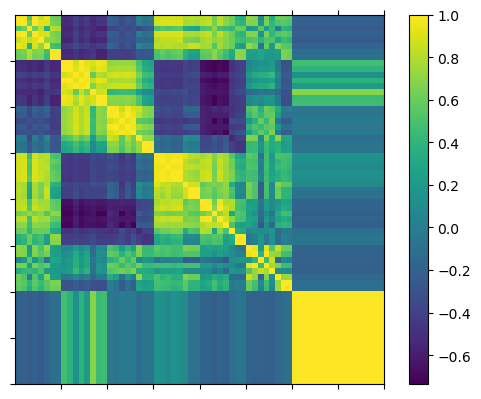

In [18]:
# visualize the correlations of the columns:
figure1 = plt.figure()
axes1 = figure1.add_subplot(111)

caxes = axes1.matshow(master_database_wo_duplicates.iloc[:, 0:64].corr())
figure1.colorbar(caxes)

ticks = [7.5, 15.5, 23.5, 31.5, 39.5, 47.5, 55.5, 63.5]
axes1.set_xticks(ticks)
axes1.set_yticks(ticks)
axes1.set_xticklabels(['' , '' , '', '', '' , '', '' , ''])
axes1.set_yticklabels(['' , '' , '', '', '' , '', '' , ''])

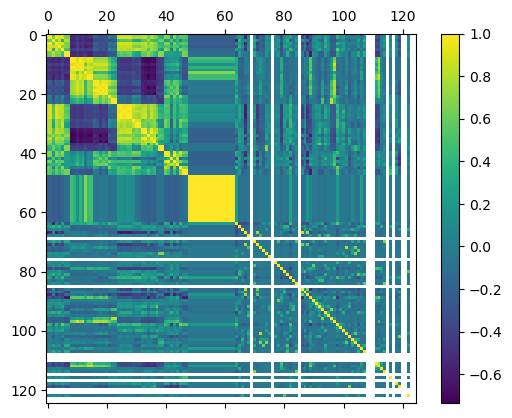

In [30]:
figure2 = plt.figure()
axes2 = figure2.add_subplot(111)

caxes = axes2.matshow(master_database_wo_duplicates.iloc[:, 0:-1].corr())
figure2.colorbar(caxes)

# ticks = [7.5, 15.5, 23.5, 31.5, 39.5, 47.5, 55.5, 63.5]
# axes2.set_xticks(ticks)
# axes2.set_yticks(ticks)
# axes1.set_xticklabels(['' , '' , '', '', '' , '', '' , ''])
# axes1.set_yticklabels(['' , '' , '', '', '' , '', '' , ''])

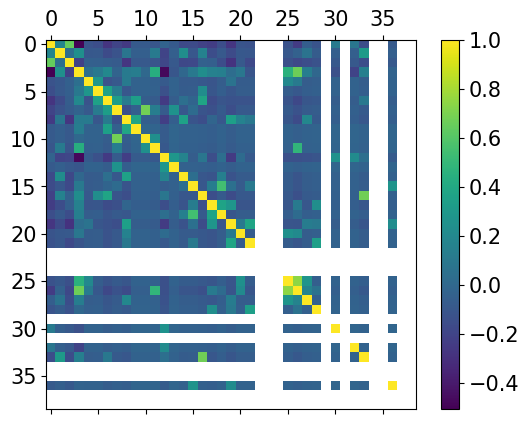

In [170]:
figure2 = plt.figure()
axes2 = figure2.add_subplot(111)

caxes = axes2.matshow(master_database_wo_duplicates.iloc[:, 86:-1].corr())
figure2.colorbar(caxes)

In [174]:
master_database_wo_duplicates.iloc[:, 86:-1].loc[:, (master_database_wo_duplicates.iloc[:, 86:-1] != 0).any(axis=0)].columns

Index(['Bi', 'Ca', 'Fe', 'O', 'Gd', 'Cr', 'Sr', 'Ta', 'Ni', 'Mo', 'Li', 'Cu',
       'Ba', 'Sc', 'W', 'Co', 'Nb', 'La', 'Mg', 'Mn', 'Eu', 'Dy', 'Na', 'Ti',
       'Sm', 'Zn', 'V', 'Nd', 'In', 'Tb'],
      dtype='object')

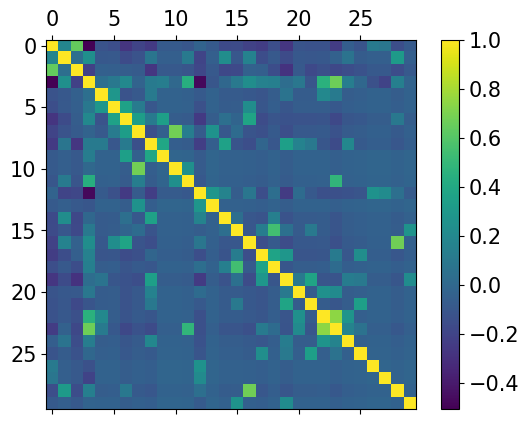

In [175]:
figure2 = plt.figure()
axes2 = figure2.add_subplot(111)

caxes = axes2.matshow(master_database_wo_duplicates.iloc[:, 86:-1].loc[:, (master_database_wo_duplicates.iloc[:, 86:-1] != 0).any(axis=0)].corr())
figure2.colorbar(caxes)

# Regression on all Elemental features

Mean squared error: 0.002
Median squared error: 0.000
Coefficient of determination: 0.997


Text(0.5, 1.0, 'Linear Regression directly on 48 features')

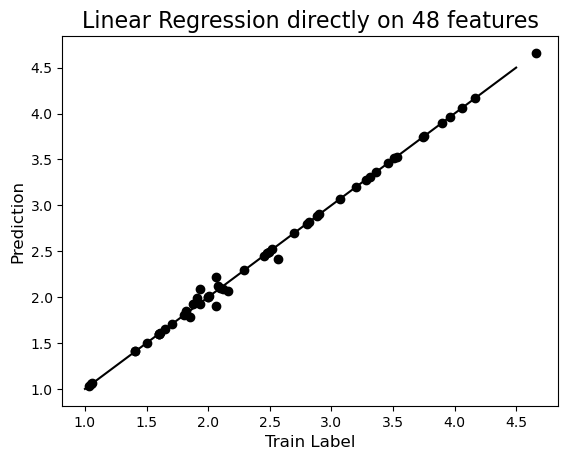

In [91]:
x = master_database_wo_duplicates_std[:, :48]
y = Bandgap_54x

regr = linear_model.LinearRegression()
regr.fit(x, y) # shape 60x64 and 60x1

test_lbl_pred = regr.predict(x)

print("Mean squared error: %.3f" % mean_squared_error(y, test_lbl_pred)); print("Median squared error: %.3f" % median_absolute_error(y, test_lbl_pred)); print("Coefficient of determination: %.3f" % r2_score(y, test_lbl_pred))

plt.scatter(y, test_lbl_pred, color="black")
plt.plot([1, 4.5], [1, 4.5], 'k-') ; plt.xlabel('Train Label', fontsize = 12); plt.ylabel('Prediction', fontsize = 12); plt.title('Linear Regression directly on '+ str(x.shape[1]) +' features', fontsize = 16)

Above is how the results of linear regression look like for training. Next, we will look on leave-one-out performance on test data. In leave one out method, we train as many models as there are data in the dataset and train on all data points but one which is left for testing. Results are bellow:

Mean squared error: 27076540362745811304448.000
Median squared error: 3069203327.476
Coefficient of determination: -34680424027722220568576.000


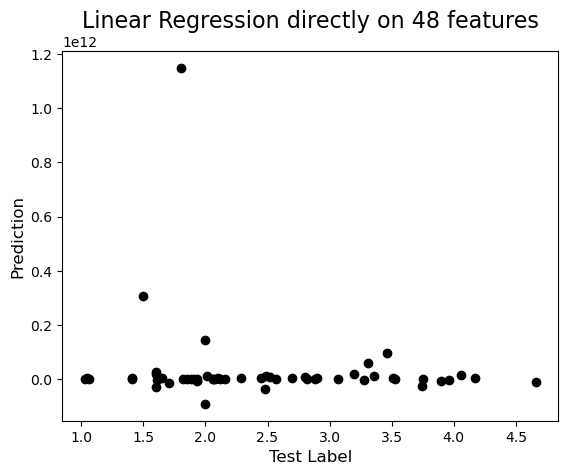

In [93]:
loo = LeaveOneOut(); regr = linear_model.LinearRegression()

x = master_database_wo_duplicates_std[:, :48]
Y = np.array(Bandgap_54x)

real_bandgap = []
results = []

for train_index, test_index in loo.split(x):
    X_train, X_test = x[train_index], x[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    regr.fit(X_train, y_train.ravel())
    test_lbl_pred = regr.predict(X_test)
#    print(test_lbl_pred)
    real_bandgap.append(y_test)#[0][0])
    results.append(test_lbl_pred[0])

plt.scatter(real_bandgap, results, color="black")
plt.xlabel('Test Label', fontsize = 12); plt.ylabel('Prediction', fontsize = 12)
plt.title('Linear Regression directly on '+ str(x.shape[1]) +' features', fontsize = 16)
print("Mean squared error: %.3f" % mean_squared_error(real_bandgap, results))
print("Median absolute error: %.3f" % median_absolute_error(real_bandgap, results))
print("Coefficient of determination: %.3f" % r2_score(real_bandgap, results))
del[[x, real_bandgap, results, Y]]

In [ ]:
We can see that Linear regres

# Tpot default usage with 32 features:

In [81]:
%%time
import tpot
from tpot import TPOTRegressor
from sklearn.model_selection import train_test_split

X = master_database_wo_duplicates.iloc[:, :32].to_numpy()
y = np.array(Bandgap_54x)

tpot = TPOTRegressor(generations=10, population_size=50, verbosity=2, random_state=42,
                     #config_dict=tpot_config
                     cv=LeaveOneOut())
#                    )

# uncoment this to run it:
# tpot.fit(X, y)
# print(tpot.score(X, y))
# tpot.export('tpot-64features.py')

CPU times: user 1.64 ms, sys: 624 µs, total: 2.26 ms
Wall time: 1.83 ms


Mean squared error: 0.35
Median absolute error: 0.35
Coefficient of determination: 0.55


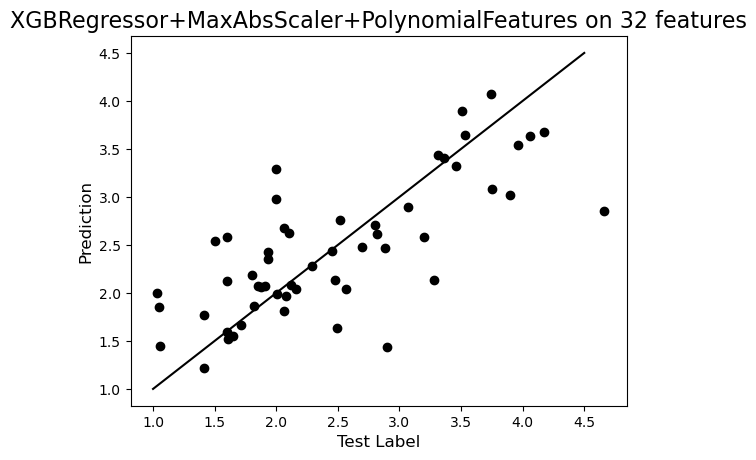

In [72]:
from sklearn.preprocessing import MaxAbsScaler, PolynomialFeatures
from xgboost import XGBRegressor
from tpot.export_utils import set_param_recursive

# Average CV score on the training set was: -0.3520912808444582
exported_pipeline = make_pipeline(
    MaxAbsScaler(),
    PolynomialFeatures(degree=2, include_bias=False, interaction_only=False),
    XGBRegressor(learning_rate=0.1, max_depth=8, min_child_weight=3, n_estimators=100, n_jobs=1, objective="reg:squarederror", subsample=0.4, verbosity=0)
)
# Fix random state for all the steps in exported pipeline
set_param_recursive(exported_pipeline.steps, 'random_state', 42)

loo = LeaveOneOut()
X = master_database_wo_duplicates.iloc[:, :32].to_numpy()
y = np.array(Bandgap_54x)

real_bandgap = []
results = []
Model = 'XGBRegressor+MaxAbsScaler+PolynomialFeatures'

X = master_database_wo_duplicates.iloc[:, :32].to_numpy()
y = np.array(Bandgap_54x)

for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    exported_pipeline.fit(X_train, y_train.ravel())
    test_lbl_pred = exported_pipeline.predict(X_test)

    real_bandgap.append(y_test)
    results.append(test_lbl_pred[0])
    #print(y_test)
    #print(test_lbl_pred[0])

# Plot outputs
plt.scatter(real_bandgap, results, color="black")
plt.plot([1, 4.5], [1, 4.5], 'k-')
plt.xlabel('Test Label', fontsize = 12)
plt.ylabel('Prediction', fontsize = 12)
plt.title(str(Model)+' on '+ str(X.shape[1]) +' features', fontsize = 16)
print("Mean squared error: %.2f" % mean_squared_error(real_bandgap, results))
print("Median absolute error: %.2f" % median_absolute_error(real_bandgap, results))
print("Coefficient of determination: %.2f" % r2_score(real_bandgap, results))
del[[real_bandgap, results, y, X]]

Mean squared error: 0.02
Median absolute error: 0.06
Coefficient of determination: 0.98


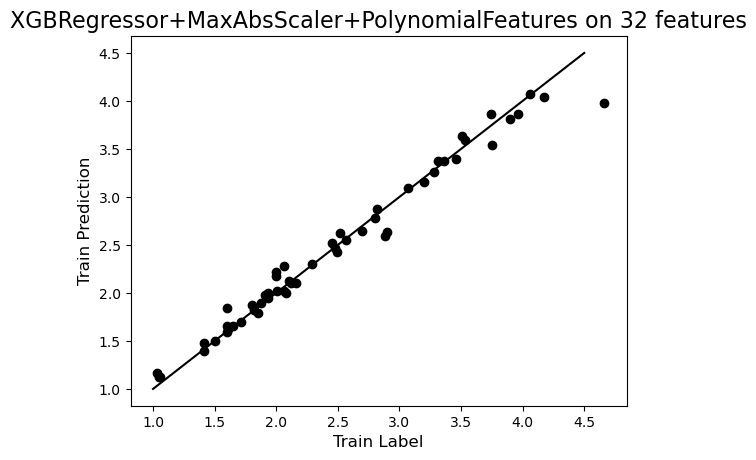

In [74]:
real_bandgap = []
results = []
Model = 'XGBRegressor+MaxAbsScaler+PolynomialFeatures'

X = master_database_wo_duplicates.iloc[:, :32].to_numpy()
y = np.array(Bandgap_54x)

exported_pipeline.fit(X, y.ravel())
test_lbl_pred = exported_pipeline.predict(X)

plt.scatter(y, test_lbl_pred, color="black")
plt.plot([1, 4.5], [1, 4.5], 'k-')
plt.xlabel('Train Label', fontsize = 12)
plt.ylabel('Train Prediction', fontsize = 12)
plt.title(str(Model)+' on '+ str(X.shape[1]) +' features', fontsize = 16)
print("Mean squared error: %.2f" % mean_squared_error(y, test_lbl_pred))
print("Median absolute error: %.2f" % median_absolute_error(y, test_lbl_pred))
print("Coefficient of determination: %.2f" % r2_score(y, test_lbl_pred))
del[[X, y]]

# Tpot default usage with 64

In [32]:
master_database_wo_duplicates.shape

(54, 126)

In [83]:
%%time
import tpot
from tpot import TPOTRegressor
from sklearn.model_selection import train_test_split

X = master_database_wo_duplicates.iloc[:, :64].to_numpy()
y = np.array(Bandgap_54x)

tpot = TPOTRegressor(generations=10, population_size=50, verbosity=3, random_state=42,
                     #config_dict=tpot_config
                     cv=LeaveOneOut())
#                    )

# tpot.fit(X_train, y_train)
tpot.fit(X, y)
print(tpot.score(X, y))
tpot.export('tpot-64features.py')

30 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/550 [00:00<?, ?pipeline/s]

_pre_test decorator: _random_mutation_operator: num_test=0 l1 was provided as affinity. Ward can only work with euclidean distances..
_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l2' and loss='epsilon_insensitive' are not supported when dual=False, Parameters: penalty='l2', loss='epsilon_insensitive', dual=False.
_pre_test decorator: _random_mutation_operator: num_test=1 Found array with 0 feature(s) (shape=(48, 0)) while a minimum of 1 is required..
_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(48, 0)) while a minimum of 1 is required..
_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(48, 0)) while a minimum of 1 is required..

Generation 1 - Current Pareto front scores:

-1	-0.36926923499601766	XGBRegressor(input_matrix, XGBRegressor__learning_rate=0.1, XGBRegressor__max_depth=8, XGBRegressor__min_child_weight=3, XG

_pre_test decorator: _random_mutation_operator: num_test=0 [20:43:19] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:792: Check failed: mparam_.num_feature != 0 (0 vs. 0) : 0 feature is supplied.  Are you using raw Booster interface?
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x0000000291e64260 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x0000000291f54df0 xgboost::LearnerConfiguration::ConfigureNumFeatures() + 820
  [bt] (2) 3   libxgboost.dylib                    0x0000000291f4a2cc xgboost::LearnerConfiguration::Configure() + 884
  [bt] (3) 4   libxgboost.dylib                    0x0000000291f4a6dc xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (4) 5   libxgboost.dylib                    0x0000000291e6a0d4 XGBoosterUpdateOneIter + 144
  [bt] (5) 6   libffi.8.dylib                      0x0000000103b

_pre_test decorator: _random_mutation_operator: num_test=0 [20:50:48] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:792: Check failed: mparam_.num_feature != 0 (0 vs. 0) : 0 feature is supplied.  Are you using raw Booster interface?
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x0000000291e64260 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x0000000291f54df0 xgboost::LearnerConfiguration::ConfigureNumFeatures() + 820
  [bt] (2) 3   libxgboost.dylib                    0x0000000291f4a2cc xgboost::LearnerConfiguration::Configure() + 884
  [bt] (3) 4   libxgboost.dylib                    0x0000000291f4a6dc xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (4) 5   libxgboost.dylib                    0x0000000291e6a0d4 XGBoosterUpdateOneIter + 144
  [bt] (5) 6   libffi.8.dylib                      0x0000000103b

Mean squared error: 0.30
Median absolute error: 0.26
Coefficient of determination: 0.61


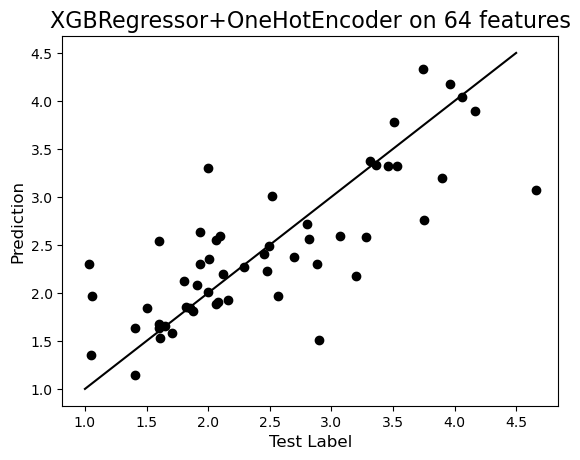

In [88]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from tpot.builtins import OneHotEncoder
from xgboost import XGBRegressor
from tpot.export_utils import set_param_recursive

exported_pipeline = make_pipeline(
    OneHotEncoder(minimum_fraction=0.15, sparse=False, threshold=10),
    XGBRegressor(learning_rate=0.5, max_depth=5, min_child_weight=5, n_estimators=100, n_jobs=1, objective="reg:squarederror", subsample=0.8, verbosity=0)
)
# Fix random state for all the steps in exported pipeline
set_param_recursive(exported_pipeline.steps, 'random_state', 42)

loo = LeaveOneOut()
X = master_database_wo_duplicates.iloc[:, :64].to_numpy()
y = np.array(Bandgap_54x)

real_bandgap = []
results = []
Model = 'XGBRegressor+OneHotEncoder'

for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    exported_pipeline.fit(X_train, y_train.ravel())
    test_lbl_pred = exported_pipeline.predict(X_test)

    real_bandgap.append(y_test)
    results.append(test_lbl_pred[0])
    #print(y_test)
    #print(test_lbl_pred[0])

# Plot outputs
plt.scatter(real_bandgap, results, color="black")
plt.plot([1, 4.5], [1, 4.5], 'k-')
plt.xlabel('Test Label', fontsize = 12)
plt.ylabel('Prediction', fontsize = 12)
plt.title(str(Model)+' on '+ str(X.shape[1]) +' features', fontsize = 16)
print("Mean squared error: %.2f" % mean_squared_error(real_bandgap, results))
print("Median absolute error: %.2f" % median_absolute_error(real_bandgap, results))
print("Coefficient of determination: %.2f" % r2_score(real_bandgap, results))
del[[real_bandgap, results, y, X]]

Mean squared error: 0.00
Median absolute error: 0.00
Coefficient of determination: 1.00


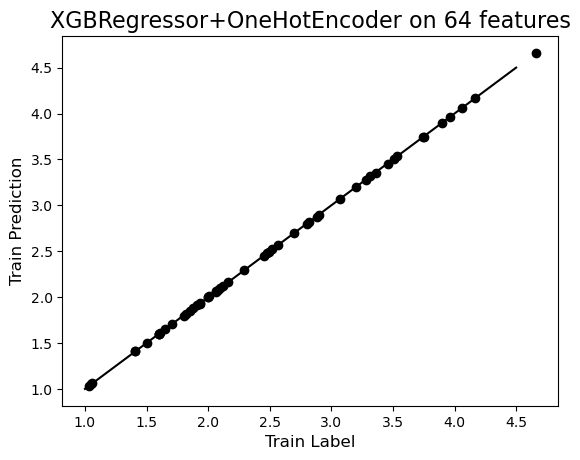

In [89]:
real_bandgap = []
results = []

X = master_database_wo_duplicates.iloc[:, :64].to_numpy()
y = np.array(Bandgap_54x)

exported_pipeline.fit(X, y.ravel())
test_lbl_pred = exported_pipeline.predict(X)

plt.scatter(y, test_lbl_pred, color="black")
plt.plot([1, 4.5], [1, 4.5], 'k-')
plt.xlabel('Train Label', fontsize = 12)
plt.ylabel('Train Prediction', fontsize = 12)
plt.title(str(Model)+' on '+ str(X.shape[1]) +' features', fontsize = 16)
print("Mean squared error: %.2f" % mean_squared_error(y, test_lbl_pred))
print("Median absolute error: %.2f" % median_absolute_error(y, test_lbl_pred))
print("Coefficient of determination: %.2f" % r2_score(y, test_lbl_pred))
del[[X, y]]

# Complete search with Tpot

In [85]:
%%time

tpot_config = {

    'sklearn.linear_model.ElasticNetCV': {
        'l1_ratio': np.arange(0.0, 1.01, 0.05),
        'tol': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
    },

    'sklearn.ensemble.ExtraTreesRegressor': {
        'n_estimators': [100],
        'max_features': np.arange(0.05, 1.01, 0.05),
        'min_samples_split': range(2, 21),
        'min_samples_leaf': range(1, 21),
        'bootstrap': [True, False]
    },

    'sklearn.ensemble.GradientBoostingRegressor': {
        'n_estimators': [100],
        'loss': ["ls", "lad", "huber", "quantile"],
        'learning_rate': [1e-3, 1e-2, 1e-1, 0.5, 1.],
        'max_depth': range(1, 11),
        'min_samples_split': range(2, 21),
        'min_samples_leaf': range(1, 21),
        'subsample': np.arange(0.05, 1.01, 0.05),
        'max_features': np.arange(0.05, 1.01, 0.05),
        'alpha': [0.75, 0.8, 0.85, 0.9, 0.95, 0.99]
    },

    'sklearn.ensemble.AdaBoostRegressor': {
        'n_estimators': [100],
        'learning_rate': [1e-3, 1e-2, 1e-1, 0.5, 1.],
        'loss': ["linear", "square", "exponential"]
    },

    'sklearn.tree.DecisionTreeRegressor': {
        'max_depth': range(1, 11),
        'min_samples_split': range(2, 21),
        'min_samples_leaf': range(1, 21)
    },

    'sklearn.neighbors.KNeighborsRegressor': {
        'n_neighbors': range(1, 101),
        'weights': ["uniform", "distance"],
        'p': [1, 2]
    },

    'sklearn.linear_model.LassoLarsCV': {
        'normalize': [True, False]
    },

    'sklearn.svm.LinearSVR': {
        'loss': ["epsilon_insensitive", "squared_epsilon_insensitive"],
        'dual': [True, False],
        'tol': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1],
        'C': [1e-4, 1e-3, 1e-2, 1e-1, 0.5, 1., 5., 10., 15., 20., 25.],
        'epsilon': [1e-4, 1e-3, 1e-2, 1e-1, 1.]
    },

    'sklearn.ensemble.RandomForestRegressor': {
        'n_estimators': [100],
        'max_features': np.arange(0.05, 1.01, 0.05),
        'min_samples_split': range(2, 21),
        'min_samples_leaf': range(1, 21),
        'bootstrap': [True, False]
    },

    'sklearn.linear_model.RidgeCV': {
    },

    'xgboost.XGBRegressor': {
        'n_estimators': [100],
        'max_depth': range(1, 11),
        'learning_rate': [1e-3, 1e-2, 1e-1, 0.5, 1.],
        'subsample': np.arange(0.05, 1.01, 0.05),
        'min_child_weight': range(1, 21),
        'n_jobs': [1],
        'verbosity': [0],
        'objective': ['reg:squarederror']
    },

    'sklearn.linear_model.SGDRegressor': {
        'loss': ['squared_loss', 'huber', 'epsilon_insensitive'],
        'penalty': ['elasticnet'],
        'alpha': [0.0, 0.01, 0.001] ,
        'learning_rate': ['invscaling', 'constant'] ,
        'fit_intercept': [True, False],
        'l1_ratio': [0.25, 0.0, 1.0, 0.75, 0.5],
        'eta0': [0.1, 1.0, 0.01],
        'power_t': [0.5, 0.0, 1.0, 0.1, 100.0, 10.0, 50.0]
    },

    # Preprocessors
    'sklearn.preprocessing.Binarizer': {
        'threshold': np.arange(0.0, 1.01, 0.05)
    },

    'sklearn.decomposition.FastICA': {
        'tol': np.arange(0.0, 1.01, 0.05)
    },

    'sklearn.cluster.FeatureAgglomeration': {
        'linkage': ['ward', 'complete', 'average'],
        'affinity': ['euclidean', 'l1', 'l2', 'manhattan', 'cosine']
    },

    'sklearn.preprocessing.MaxAbsScaler': {
    },

    'sklearn.preprocessing.MinMaxScaler': {
    },

    'sklearn.preprocessing.Normalizer': {
        'norm': ['l1', 'l2', 'max']
    },

    'sklearn.kernel_approximation.Nystroem': {
        'kernel': ['rbf', 'cosine', 'chi2', 'laplacian', 'polynomial', 'poly', 'linear', 'additive_chi2', 'sigmoid'],
        'gamma': np.arange(0.0, 1.01, 0.05),
        'n_components': range(1, 11)
    },

    'sklearn.decomposition.PCA': {
        'svd_solver': ['randomized'],
        'iterated_power': range(1, 11)
    },

    'sklearn.preprocessing.PolynomialFeatures': {
        'degree': [2],
        'include_bias': [False],
        'interaction_only': [False]
    },

    'sklearn.kernel_approximation.RBFSampler': {
        'gamma': np.arange(0.0, 1.01, 0.05)
    },

    'sklearn.preprocessing.RobustScaler': {
    },

    'sklearn.preprocessing.StandardScaler': {
    },

    'tpot.builtins.ZeroCount': {
    },

    'tpot.builtins.OneHotEncoder': {
        'minimum_fraction': [0.05, 0.1, 0.15, 0.2, 0.25],
        'sparse': [False],
        'threshold': [10]
    },


    # Selectors
    'sklearn.feature_selection.SelectFwe': {
        'alpha': np.arange(0, 0.05, 0.001),
        'score_func': {
            'sklearn.feature_selection.f_regression': None
        }
    },

    'sklearn.feature_selection.SelectPercentile': {
        'percentile': range(1, 100),
        'score_func': {
            'sklearn.feature_selection.f_regression': None
        }
    },

    'sklearn.feature_selection.VarianceThreshold': {
        'threshold': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.2]
    },

    'sklearn.feature_selection.SelectFromModel': {
        'threshold': np.arange(0, 1.01, 0.05),
        'estimator': {
            'sklearn.ensemble.ExtraTreesRegressor': {
                'n_estimators': [100],
                'max_features': np.arange(0.05, 1.01, 0.05)
            }
        }
    }

}

X = master_database_wo_duplicates.iloc[:, :32].to_numpy()
y = np.array(Bandgap_54x)

tpot = TPOTRegressor(generations=10, population_size=50, verbosity=3, random_state=42,
                     config_dict=tpot_config,
                     cv=LeaveOneOut())

tpot.fit(X, y)
print(tpot.score(X, y))
tpot.export('tpot-full-search-32-features.py')

30 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/550 [00:00<?, ?pipeline/s]

_pre_test decorator: _random_mutation_operator: num_test=0 l1 was provided as affinity. Ward can only work with euclidean distances..
_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l2' and loss='epsilon_insensitive' are not supported when dual=False, Parameters: penalty='l2', loss='epsilon_insensitive', dual=False.
_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(48, 0)) while a minimum of 1 is required..
_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l2' and loss='epsilon_insensitive' are not supported when dual=False, Parameters: penalty='l2', loss='epsilon_insensitive', dual=False.
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.
Pipeline encountered that has previously been evaluated during the optimization proce

_pre_test decorator: _random_mutation_operator: num_test=0 [21:09:03] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:792: Check failed: mparam_.num_feature != 0 (0 vs. 0) : 0 feature is supplied.  Are you using raw Booster interface?
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x0000000291e64260 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x0000000291f54df0 xgboost::LearnerConfiguration::ConfigureNumFeatures() + 820
  [bt] (2) 3   libxgboost.dylib                    0x0000000291f4a2cc xgboost::LearnerConfiguration::Configure() + 884
  [bt] (3) 4   libxgboost.dylib                    0x0000000291f4a6dc xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (4) 5   libxgboost.dylib                    0x0000000291e6a0d4 XGBoosterUpdateOneIter + 144
  [bt] (5) 6   libffi.8.dylib                      0x0000000103b

_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 48, n_neighbors = 67.

Generation 8 - Current Pareto front scores:

-1	-0.37409046805915525	XGBRegressor(input_matrix, XGBRegressor__learning_rate=0.1, XGBRegressor__max_depth=9, XGBRegressor__min_child_weight=3, XGBRegressor__n_estimators=100, XGBRegressor__n_jobs=1, XGBRegressor__objective=reg:squarederror, XGBRegressor__subsample=0.45, XGBRegressor__verbosity=0)

-2	-0.3537731343679859	XGBRegressor(GradientBoostingRegressor(input_matrix, GradientBoostingRegressor__alpha=0.95, GradientBoostingRegressor__learning_rate=0.001, GradientBoostingRegressor__loss=quantile, GradientBoostingRegressor__max_depth=1, GradientBoostingRegressor__max_features=0.7000000000000001, GradientBoostingRegressor__min_samples_leaf=19, GradientBoostingRegressor__min_samples_split=20, GradientBoostingRegressor__n_estimators=100, GradientBoostingRegressor__subsample=0.7500000000000001), XGBRegressor__l

Mean squared error: 0.35
Median absolute error: 0.35
Coefficient of determination: 0.55


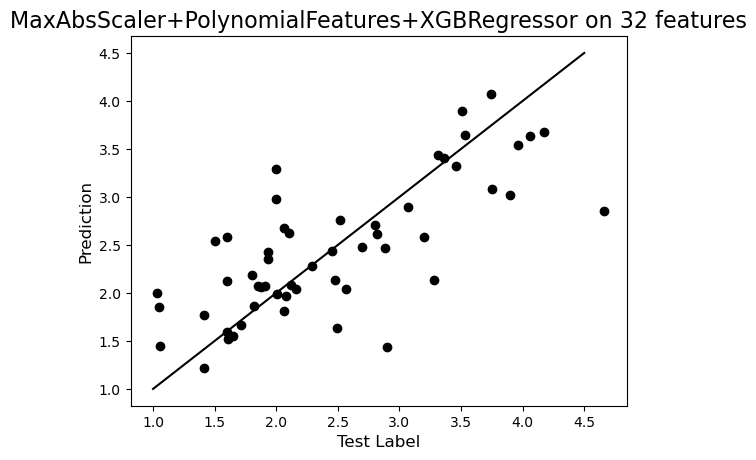

In [96]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MaxAbsScaler, PolynomialFeatures
from xgboost import XGBRegressor
from tpot.export_utils import set_param_recursive

exported_pipeline = make_pipeline(
    MaxAbsScaler(),
    PolynomialFeatures(degree=2, include_bias=False, interaction_only=False),
    XGBRegressor(learning_rate=0.1, max_depth=8, min_child_weight=3, n_estimators=100, n_jobs=1, objective="reg:squarederror", subsample=0.4, verbosity=0)
)
# Fix random state for all the steps in exported pipeline
set_param_recursive(exported_pipeline.steps, 'random_state', 42)


loo = LeaveOneOut()
X = master_database_wo_duplicates.iloc[:, :32].to_numpy()
y = np.array(Bandgap_54x)

real_bandgap = []
results = []
Model = 'MaxAbsScaler+PolynomialFeatures+XGBRegressor'

for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    exported_pipeline.fit(X_train, y_train.ravel())
    test_lbl_pred = exported_pipeline.predict(X_test)

    real_bandgap.append(y_test)
    results.append(test_lbl_pred[0])
    #print(y_test)
    #print(test_lbl_pred[0])

# Plot outputs
plt.scatter(real_bandgap, results, color="black")
plt.plot([1, 4.5], [1, 4.5], 'k-')
plt.xlabel('Test Label', fontsize = 12)
plt.ylabel('Prediction', fontsize = 12)
plt.title(str(Model)+' on '+ str(X.shape[1]) +' features', fontsize = 16)
print("Mean squared error: %.2f" % mean_squared_error(real_bandgap, results))
print("Median absolute error: %.2f" % median_absolute_error(real_bandgap, results))
print("Coefficient of determination: %.2f" % r2_score(real_bandgap, results))
del[[real_bandgap, results, y, X]]

Mean squared error: 0.02
Median absolute error: 0.06
Coefficient of determination: 0.98


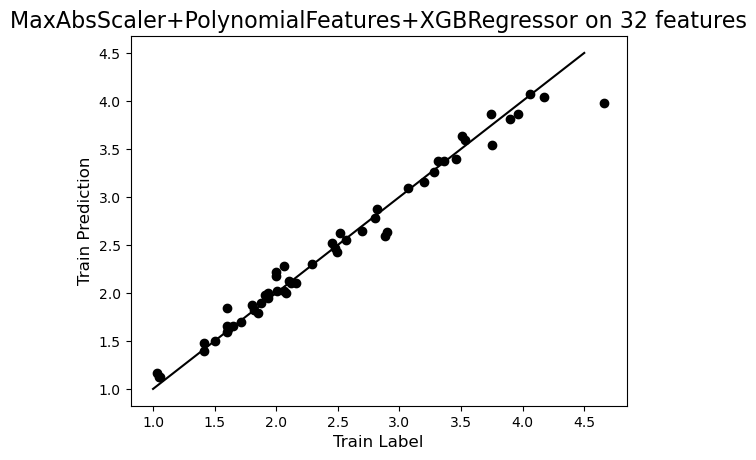

In [97]:
real_bandgap = []
results = []

X = master_database_wo_duplicates.iloc[:, :32].to_numpy()
y = np.array(Bandgap_54x)

exported_pipeline.fit(X, y.ravel())
test_lbl_pred = exported_pipeline.predict(X)

plt.scatter(y, test_lbl_pred, color="black")
plt.plot([1, 4.5], [1, 4.5], 'k-')
plt.xlabel('Train Label', fontsize = 12)
plt.ylabel('Train Prediction', fontsize = 12)
plt.title(str(Model)+' on '+ str(X.shape[1]) +' features', fontsize = 16)
print("Mean squared error: %.2f" % mean_squared_error(y, test_lbl_pred))
print("Median absolute error: %.2f" % median_absolute_error(y, test_lbl_pred))
print("Coefficient of determination: %.2f" % r2_score(y, test_lbl_pred))
del[[X, y]]

Old results SVR:

In [ ]:
# regressor = SVR(kernel = 'rbf'); x = x_el_desc
# regressor.fit(x, y['Bandgap'].transpose())
# test_lbl_pred = regressor.predict(x)

# plt.scatter(y, test_lbl_pred, color="black")
# plt.plot([1, 4.5], [1, 4.5], 'k-')
# plt.xlabel('Train Label', fontsize = 12)
# plt.ylabel('Train Prediction', fontsize = 12)
# plt.title('Support Vector Regression on '+ str(x.shape[1]) +' features', fontsize = 16)
# print("Mean squared error: %.2f" % mean_squared_error(y, test_lbl_pred))
# print("Median absolute error: %.2f" % median_absolute_error(y, test_lbl_pred))
# print("Coefficient of determination: %.2f" % r2_score(y, test_lbl_pred))
# del[[x, regressor, test_lbl_pred]]

In [ ]:
# loo = LeaveOneOut(); Y = np.array(y)
# x = x_el_desc
# regressor = SVR(kernel = 'rbf')

# real_bandgap = []
# results = []

# for train_index, test_index in loo.split(x):
#     X_train, X_test = x[train_index], x[test_index]
#     y_train, y_test = Y[train_index], Y[test_index]
    
#     regressor.fit(X_train, y_train.ravel())
#     test_lbl_pred = regressor.predict(X_test)

#     real_bandgap.append(y_test[0][0])
#     results.append(test_lbl_pred[0])

# # Plot outputs
# plt.scatter(real_bandgap, results, color="black")
# plt.plot([1, 4.5], [1, 4.5], 'k-')
# plt.xlabel('Test Label', fontsize = 12)
# plt.ylabel('Prediction', fontsize = 12)
# # plt.xlabel('Train Label', fontsize = 12)
# # plt.ylabel('Prediction', fontsize = 12)
# plt.title('SVR Regression directly on '+ str(x.shape[1]) +' features', fontsize = 16)
# print("Mean squared error: %.2f" % mean_squared_error(real_bandgap, results))
# print("Median absolute error: %.2f" % median_absolute_error(real_bandgap, results))
# print("Coefficient of determination: %.2f" % r2_score(real_bandgap, results))
# del[[x, real_bandgap, results, Y]]

# Complete search with 48 features

In [98]:
%%time

tpot_config = {

    'sklearn.linear_model.ElasticNetCV': {
        'l1_ratio': np.arange(0.0, 1.01, 0.05),
        'tol': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
    },

    'sklearn.ensemble.ExtraTreesRegressor': {
        'n_estimators': [100],
        'max_features': np.arange(0.05, 1.01, 0.05),
        'min_samples_split': range(2, 21),
        'min_samples_leaf': range(1, 21),
        'bootstrap': [True, False]
    },

    'sklearn.ensemble.GradientBoostingRegressor': {
        'n_estimators': [100],
        'loss': ["ls", "lad", "huber", "quantile"],
        'learning_rate': [1e-3, 1e-2, 1e-1, 0.5, 1.],
        'max_depth': range(1, 11),
        'min_samples_split': range(2, 21),
        'min_samples_leaf': range(1, 21),
        'subsample': np.arange(0.05, 1.01, 0.05),
        'max_features': np.arange(0.05, 1.01, 0.05),
        'alpha': [0.75, 0.8, 0.85, 0.9, 0.95, 0.99]
    },

    'sklearn.ensemble.AdaBoostRegressor': {
        'n_estimators': [100],
        'learning_rate': [1e-3, 1e-2, 1e-1, 0.5, 1.],
        'loss': ["linear", "square", "exponential"]
    },

    'sklearn.tree.DecisionTreeRegressor': {
        'max_depth': range(1, 11),
        'min_samples_split': range(2, 21),
        'min_samples_leaf': range(1, 21)
    },

    'sklearn.neighbors.KNeighborsRegressor': {
        'n_neighbors': range(1, 101),
        'weights': ["uniform", "distance"],
        'p': [1, 2]
    },

    'sklearn.linear_model.LassoLarsCV': {
        'normalize': [True, False]
    },

    'sklearn.svm.LinearSVR': {
        'loss': ["epsilon_insensitive", "squared_epsilon_insensitive"],
        'dual': [True, False],
        'tol': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1],
        'C': [1e-4, 1e-3, 1e-2, 1e-1, 0.5, 1., 5., 10., 15., 20., 25.],
        'epsilon': [1e-4, 1e-3, 1e-2, 1e-1, 1.]
    },

    'sklearn.ensemble.RandomForestRegressor': {
        'n_estimators': [100],
        'max_features': np.arange(0.05, 1.01, 0.05),
        'min_samples_split': range(2, 21),
        'min_samples_leaf': range(1, 21),
        'bootstrap': [True, False]
    },

    'sklearn.linear_model.RidgeCV': {
    },

    'xgboost.XGBRegressor': {
        'n_estimators': [100],
        'max_depth': range(1, 11),
        'learning_rate': [1e-3, 1e-2, 1e-1, 0.5, 1.],
        'subsample': np.arange(0.05, 1.01, 0.05),
        'min_child_weight': range(1, 21),
        'n_jobs': [1],
        'verbosity': [0],
        'objective': ['reg:squarederror']
    },

    'sklearn.linear_model.SGDRegressor': {
        'loss': ['squared_loss', 'huber', 'epsilon_insensitive'],
        'penalty': ['elasticnet'],
        'alpha': [0.0, 0.01, 0.001] ,
        'learning_rate': ['invscaling', 'constant'] ,
        'fit_intercept': [True, False],
        'l1_ratio': [0.25, 0.0, 1.0, 0.75, 0.5],
        'eta0': [0.1, 1.0, 0.01],
        'power_t': [0.5, 0.0, 1.0, 0.1, 100.0, 10.0, 50.0]
    },

    # Preprocessors
    'sklearn.preprocessing.Binarizer': {
        'threshold': np.arange(0.0, 1.01, 0.05)
    },

    'sklearn.decomposition.FastICA': {
        'tol': np.arange(0.0, 1.01, 0.05)
    },

    'sklearn.cluster.FeatureAgglomeration': {
        'linkage': ['ward', 'complete', 'average'],
        'affinity': ['euclidean', 'l1', 'l2', 'manhattan', 'cosine']
    },

    'sklearn.preprocessing.MaxAbsScaler': {
    },

    'sklearn.preprocessing.MinMaxScaler': {
    },

    'sklearn.preprocessing.Normalizer': {
        'norm': ['l1', 'l2', 'max']
    },

    'sklearn.kernel_approximation.Nystroem': {
        'kernel': ['rbf', 'cosine', 'chi2', 'laplacian', 'polynomial', 'poly', 'linear', 'additive_chi2', 'sigmoid'],
        'gamma': np.arange(0.0, 1.01, 0.05),
        'n_components': range(1, 11)
    },

    'sklearn.decomposition.PCA': {
        'svd_solver': ['randomized'],
        'iterated_power': range(1, 11)
    },

    'sklearn.preprocessing.PolynomialFeatures': {
        'degree': [2],
        'include_bias': [False],
        'interaction_only': [False]
    },

    'sklearn.kernel_approximation.RBFSampler': {
        'gamma': np.arange(0.0, 1.01, 0.05)
    },

    'sklearn.preprocessing.RobustScaler': {
    },

    'sklearn.preprocessing.StandardScaler': {
    },

    'tpot.builtins.ZeroCount': {
    },

    'tpot.builtins.OneHotEncoder': {
        'minimum_fraction': [0.05, 0.1, 0.15, 0.2, 0.25],
        'sparse': [False],
        'threshold': [10]
    },


    # Selectors
    'sklearn.feature_selection.SelectFwe': {
        'alpha': np.arange(0, 0.05, 0.001),
        'score_func': {
            'sklearn.feature_selection.f_regression': None
        }
    },

    'sklearn.feature_selection.SelectPercentile': {
        'percentile': range(1, 100),
        'score_func': {
            'sklearn.feature_selection.f_regression': None
        }
    },

    'sklearn.feature_selection.VarianceThreshold': {
        'threshold': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.2]
    },

    'sklearn.feature_selection.SelectFromModel': {
        'threshold': np.arange(0, 1.01, 0.05),
        'estimator': {
            'sklearn.ensemble.ExtraTreesRegressor': {
                'n_estimators': [100],
                'max_features': np.arange(0.05, 1.01, 0.05)
            }
        }
    }

}

X = master_database_wo_duplicates.iloc[:, :48].to_numpy()
y = np.array(Bandgap_54x)

tpot = TPOTRegressor(generations=10, population_size=50, verbosity=3, random_state=42,
                     config_dict=tpot_config,
                     cv=LeaveOneOut())

tpot.fit(X, y)
print(tpot.score(X, y))
tpot.export('tpot-full-search-48-features.py')

30 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/550 [00:00<?, ?pipeline/s]

_pre_test decorator: _random_mutation_operator: num_test=0 l1 was provided as affinity. Ward can only work with euclidean distances..
_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l2' and loss='epsilon_insensitive' are not supported when dual=False, Parameters: penalty='l2', loss='epsilon_insensitive', dual=False.
_pre_test decorator: _random_mutation_operator: num_test=1 Found array with 0 feature(s) (shape=(48, 0)) while a minimum of 1 is required..
_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(48, 0)) while a minimum of 1 is required..
_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(48, 0)) while a minimum of 1 is required..
_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(48, 0)) while a minimum of 1 is required..
_pre_test decorator: _random_mutation_operator: num_t

_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 48, n_neighbors = 70.
_pre_test decorator: _random_mutation_operator: num_test=0 [22:29:15] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:792: Check failed: mparam_.num_feature != 0 (0 vs. 0) : 0 feature is supplied.  Are you using raw Booster interface?
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x0000000291e64260 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x0000000291f54df0 xgboost::LearnerConfiguration::ConfigureNumFeatures() + 820
  [bt] (2) 3   libxgboost.dylib                    0x0000000291f4a2cc xgboost::LearnerConfiguration::Configure() + 884
  [bt] (3) 4   libxgboost.dylib                    0x0000000291f4a6dc xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (4) 5   libxgboost.dyli

_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(48, 0)) while a minimum of 1 is required..

Generation 9 - Current Pareto front scores:

-1	-0.349867365245755	XGBRegressor(input_matrix, XGBRegressor__learning_rate=1.0, XGBRegressor__max_depth=3, XGBRegressor__min_child_weight=4, XGBRegressor__n_estimators=100, XGBRegressor__n_jobs=1, XGBRegressor__objective=reg:squarederror, XGBRegressor__subsample=0.8, XGBRegressor__verbosity=0)

-2	-0.3271881835125627	XGBRegressor(XGBRegressor(input_matrix, XGBRegressor__learning_rate=0.001, XGBRegressor__max_depth=2, XGBRegressor__min_child_weight=10, XGBRegressor__n_estimators=100, XGBRegressor__n_jobs=1, XGBRegressor__objective=reg:squarederror, XGBRegressor__subsample=1.0, XGBRegressor__verbosity=0), XGBRegressor__learning_rate=0.1, XGBRegressor__max_depth=10, XGBRegressor__min_child_weight=5, XGBRegressor__n_estimators=100, XGBRegressor__n_jobs=1, XGBRegressor__objective=reg:squarederror, XGBRegre

Mean squared error: 0.30
Median absolute error: 0.24
Coefficient of determination: 0.62


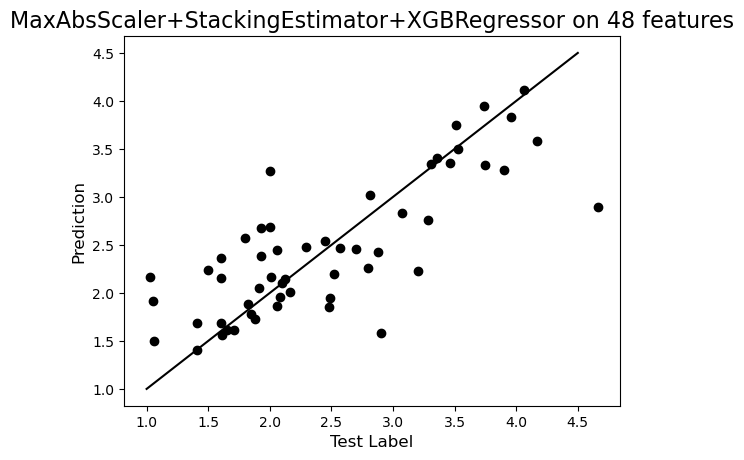

In [105]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import MaxAbsScaler
from tpot.builtins import StackingEstimator
from xgboost import XGBRegressor
from tpot.export_utils import set_param_recursive

# Average CV score on the training set was: -0.29814267152945106
exported_pipeline = make_pipeline(
    MaxAbsScaler(),
    StackingEstimator(estimator=ExtraTreesRegressor(bootstrap=True, max_features=0.35000000000000003, min_samples_leaf=4, min_samples_split=2, n_estimators=100)),
    XGBRegressor(learning_rate=0.1, max_depth=8, min_child_weight=3, n_estimators=100, n_jobs=1, objective="reg:squarederror", subsample=0.4, verbosity=0)
)
# Fix random state for all the steps in exported pipeline
set_param_recursive(exported_pipeline.steps, 'random_state', 42)


loo = LeaveOneOut()
X = master_database_wo_duplicates.iloc[:, :48].to_numpy()
y = np.array(Bandgap_54x)

real_bandgap = []
results = []
Model = 'MaxAbsScaler+StackingEstimator+XGBRegressor'

for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    exported_pipeline.fit(X_train, y_train.ravel())
    test_lbl_pred = exported_pipeline.predict(X_test)

    real_bandgap.append(y_test)
    results.append(test_lbl_pred[0])
    #print(y_test)
    #print(test_lbl_pred[0])

# Plot outputs
plt.scatter(real_bandgap, results, color="black")
plt.plot([1, 4.5], [1, 4.5], 'k-')
plt.xlabel('Test Label', fontsize = 12)
plt.ylabel('Prediction', fontsize = 12)
plt.title(str(Model)+' on '+ str(X.shape[1]) +' features', fontsize = 16)
print("Mean squared error: %.2f" % mean_squared_error(real_bandgap, results))
print("Median absolute error: %.2f" % median_absolute_error(real_bandgap, results))
print("Coefficient of determination: %.2f" % r2_score(real_bandgap, results))
del[[real_bandgap, results]]

Mean squared error: 0.02
Median absolute error: 0.07
Coefficient of determination: 0.97


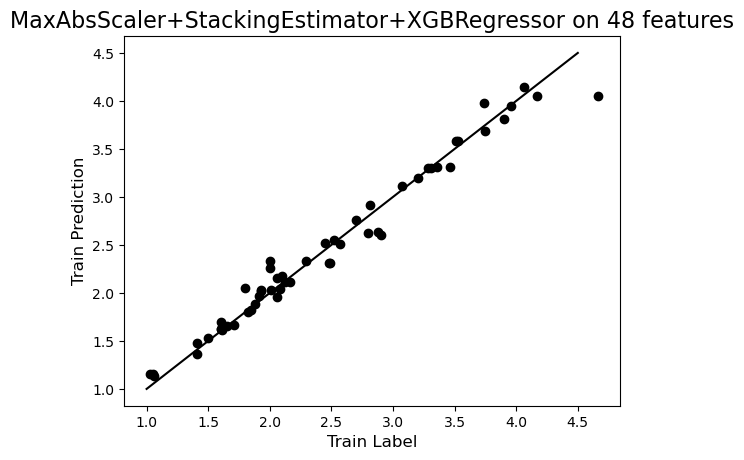

In [106]:
real_bandgap = []
results = []

exported_pipeline.fit(X, y.ravel())
test_lbl_pred = exported_pipeline.predict(X)

plt.scatter(y, test_lbl_pred, color="black")
plt.plot([1, 4.5], [1, 4.5], 'k-')
plt.xlabel('Train Label', fontsize = 12)
plt.ylabel('Train Prediction', fontsize = 12)
plt.title(str(Model)+' on '+ str(X.shape[1]) +' features', fontsize = 16)
print("Mean squared error: %.2f" % mean_squared_error(y, test_lbl_pred))
print("Median absolute error: %.2f" % median_absolute_error(y, test_lbl_pred))
print("Coefficient of determination: %.2f" % r2_score(y, test_lbl_pred))
del[[X, y, exported_pipeline, test_lbl_pred]]

# Tpot on just weight comp descriptor

In [159]:
master_database_wo_duplicates.iloc[:, 86:-1].shape

(54, 39)

In [163]:
tpot_config = {

    'sklearn.linear_model.ElasticNetCV': {
        'l1_ratio': np.arange(0.0, 1.01, 0.05),
        'tol': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
    },

    'sklearn.ensemble.ExtraTreesRegressor': {
        'n_estimators': [100],
        'max_features': np.arange(0.05, 1.01, 0.05),
        'min_samples_split': range(2, 21),
        'min_samples_leaf': range(1, 21),
        'bootstrap': [True, False]
    },

    'sklearn.ensemble.GradientBoostingRegressor': {
        'n_estimators': [100],
        'loss': ["ls", "lad", "huber", "quantile"],
        'learning_rate': [1e-3, 1e-2, 1e-1, 0.5, 1.],
        'max_depth': range(1, 11),
        'min_samples_split': range(2, 21),
        'min_samples_leaf': range(1, 21),
        'subsample': np.arange(0.05, 1.01, 0.05),
        'max_features': np.arange(0.05, 1.01, 0.05),
        'alpha': [0.75, 0.8, 0.85, 0.9, 0.95, 0.99]
    },

    'sklearn.ensemble.AdaBoostRegressor': {
        'n_estimators': [100],
        'learning_rate': [1e-3, 1e-2, 1e-1, 0.5, 1.],
        'loss': ["linear", "square", "exponential"]
    },

    'sklearn.tree.DecisionTreeRegressor': {
        'max_depth': range(1, 11),
        'min_samples_split': range(2, 21),
        'min_samples_leaf': range(1, 21)
    },

    'sklearn.neighbors.KNeighborsRegressor': {
        'n_neighbors': range(1, 101),
        'weights': ["uniform", "distance"],
        'p': [1, 2]
    },

    'sklearn.linear_model.LassoLarsCV': {
        'normalize': [True, False]
    },

    'sklearn.svm.LinearSVR': {
        'loss': ["epsilon_insensitive", "squared_epsilon_insensitive"],
        'dual': [True, False],
        'tol': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1],
        'C': [1e-4, 1e-3, 1e-2, 1e-1, 0.5, 1., 5., 10., 15., 20., 25.],
        'epsilon': [1e-4, 1e-3, 1e-2, 1e-1, 1.]
    },

    'sklearn.ensemble.RandomForestRegressor': {
        'n_estimators': [100],
        'max_features': np.arange(0.05, 1.01, 0.05),
        'min_samples_split': range(2, 21),
        'min_samples_leaf': range(1, 21),
        'bootstrap': [True, False]
    },

    'sklearn.linear_model.RidgeCV': {
    },

    'xgboost.XGBRegressor': {
        'n_estimators': [100],
        'max_depth': range(1, 11),
        'learning_rate': [1e-3, 1e-2, 1e-1, 0.5, 1.],
        'subsample': np.arange(0.05, 1.01, 0.05),
        'min_child_weight': range(1, 21),
        'n_jobs': [1],
        'verbosity': [0],
        'objective': ['reg:squarederror']
    },

    'sklearn.linear_model.SGDRegressor': {
        'loss': ['squared_loss', 'huber', 'epsilon_insensitive'],
        'penalty': ['elasticnet'],
        'alpha': [0.0, 0.01, 0.001] ,
        'learning_rate': ['invscaling', 'constant'] ,
        'fit_intercept': [True, False],
        'l1_ratio': [0.25, 0.0, 1.0, 0.75, 0.5],
        'eta0': [0.1, 1.0, 0.01],
        'power_t': [0.5, 0.0, 1.0, 0.1, 100.0, 10.0, 50.0]
    },

    # Preprocessors
    'sklearn.preprocessing.Binarizer': {
        'threshold': np.arange(0.0, 1.01, 0.05)
    },

    'sklearn.decomposition.FastICA': {
        'tol': np.arange(0.0, 1.01, 0.05)
    },

    'sklearn.cluster.FeatureAgglomeration': {
        'linkage': ['ward', 'complete', 'average'],
        'affinity': ['euclidean', 'l1', 'l2', 'manhattan', 'cosine']
    },

    'sklearn.preprocessing.MaxAbsScaler': {
    },

    'sklearn.preprocessing.MinMaxScaler': {
    },

    'sklearn.preprocessing.Normalizer': {
        'norm': ['l1', 'l2', 'max']
    },

    'sklearn.kernel_approximation.Nystroem': {
        'kernel': ['rbf', 'cosine', 'chi2', 'laplacian', 'polynomial', 'poly', 'linear', 'additive_chi2', 'sigmoid'],
        'gamma': np.arange(0.0, 1.01, 0.05),
        'n_components': range(1, 11)
    },

    'sklearn.decomposition.PCA': {
        'svd_solver': ['randomized'],
        'iterated_power': range(1, 11)
    },

    'sklearn.preprocessing.PolynomialFeatures': {
        'degree': [2],
        'include_bias': [False],
        'interaction_only': [False]
    },

    'sklearn.kernel_approximation.RBFSampler': {
        'gamma': np.arange(0.0, 1.01, 0.05)
    },

    'sklearn.preprocessing.RobustScaler': {
    },

    'sklearn.preprocessing.StandardScaler': {
    },

    'tpot.builtins.ZeroCount': {
    },

    'tpot.builtins.OneHotEncoder': {
        'minimum_fraction': [0.05, 0.1, 0.15, 0.2, 0.25],
        'sparse': [False],
        'threshold': [10]
    },


    # Selectors
    'sklearn.feature_selection.SelectFwe': {
        'alpha': np.arange(0, 0.05, 0.001),
        'score_func': {
            'sklearn.feature_selection.f_regression': None
        }
    },

    'sklearn.feature_selection.SelectPercentile': {
        'percentile': range(1, 100),
        'score_func': {
            'sklearn.feature_selection.f_regression': None
        }
    },

    'sklearn.feature_selection.VarianceThreshold': {
        'threshold': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.2]
    },

    'sklearn.feature_selection.SelectFromModel': {
        'threshold': np.arange(0, 1.01, 0.05),
        'estimator': {
            'sklearn.ensemble.ExtraTreesRegressor': {
                'n_estimators': [100],
                'max_features': np.arange(0.05, 1.01, 0.05)
            }
        }
    }

}

In [164]:
%%time

import tpot
from tpot import TPOTRegressor
from sklearn.model_selection import train_test_split

X = master_database_wo_duplicates.iloc[:, 86:-1].to_numpy()
y = np.array(Bandgap_54x)

tpot = TPOTRegressor(generations=10, population_size=50, verbosity=3, random_state=42,
                     config_dict=tpot_config,
                     cv=LeaveOneOut())

tpot.fit(X, y)
print(tpot.score(X, y))
tpot.export('tpot-weight-39-features.py')

30 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/550 [00:00<?, ?pipeline/s]

_pre_test decorator: _random_mutation_operator: num_test=0 l1 was provided as affinity. Ward can only work with euclidean distances..
_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(48, 0)) while a minimum of 1 is required..
_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 48, n_neighbors = 49.
_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 48, n_neighbors = 83.
_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l2' and loss='epsilon_insensitive' are not supported when dual=False, Parameters: penalty='l2', loss='epsilon_insensitive', dual=False.

Generation 1 - Current Pareto front scores:

-1	-0.49248681231044256	RandomForestRegressor(input_matrix, RandomForestRegressor__bootstrap=False, RandomForestRegressor__max_features=0.35000000000000003, Rand


Generation 6 - Current Pareto front scores:

-1	-0.4722442371512732	RandomForestRegressor(input_matrix, RandomForestRegressor__bootstrap=False, RandomForestRegressor__max_features=0.5, RandomForestRegressor__min_samples_leaf=1, RandomForestRegressor__min_samples_split=6, RandomForestRegressor__n_estimators=100)

-2	-0.45141474354394323	RandomForestRegressor(DecisionTreeRegressor(input_matrix, DecisionTreeRegressor__max_depth=1, DecisionTreeRegressor__min_samples_leaf=6, DecisionTreeRegressor__min_samples_split=18), RandomForestRegressor__bootstrap=False, RandomForestRegressor__max_features=0.35000000000000003, RandomForestRegressor__min_samples_leaf=1, RandomForestRegressor__min_samples_split=6, RandomForestRegressor__n_estimators=100)
_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(48, 0)) while a minimum of 1 is required..
_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penal

Mean squared error: 0.43
Median absolute error: 0.33
Coefficient of determination: 0.45


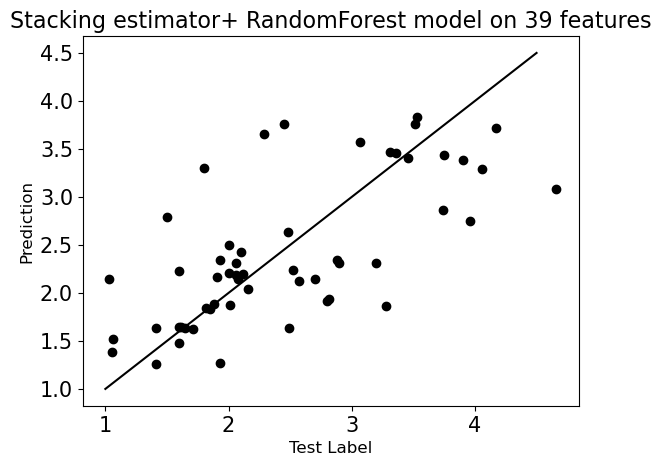

In [199]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator
from tpot.export_utils import set_param_recursive

exported_pipeline = make_pipeline(
    StackingEstimator(estimator=SGDRegressor(alpha=0.01, eta0=0.01, fit_intercept=True, l1_ratio=1.0, learning_rate="invscaling", loss="huber", penalty="elasticnet", power_t=0.1)),
    RandomForestRegressor(bootstrap=False, max_features=0.7500000000000001, min_samples_leaf=1, min_samples_split=6, n_estimators=100)
)

set_param_recursive(exported_pipeline.steps, 'random_state', 42)

loo = LeaveOneOut()
X = master_database_wo_duplicates.iloc[:, 86:-1].to_numpy()
y = np.array(Bandgap_54x)

real_bandgap = []
results = []
Model = 'Stacking estimator+ RandomForest model'

for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    exported_pipeline.fit(X_train, y_train.ravel())
    test_lbl_pred = exported_pipeline.predict(X_test)

    real_bandgap.append(y_test)
    results.append(test_lbl_pred[0])
    #print(y_test)
    #print(test_lbl_pred[0])

# Plot outputs
plt.scatter(real_bandgap, results, color="black")
plt.plot([1, 4.5], [1, 4.5], 'k-')
plt.xlabel('Test Label', fontsize = 12)
plt.ylabel('Prediction', fontsize = 12)
plt.title(str(Model)+' on '+ str(X.shape[1]) +' features', fontsize = 16)
print("Mean squared error: %.2f" % mean_squared_error(real_bandgap, results))
print("Median absolute error: %.2f" % median_absolute_error(real_bandgap, results))
print("Coefficient of determination: %.2f" % r2_score(real_bandgap, results))
del[[real_bandgap, results]]

Mean squared error: 0.048
Median absolute error: 0.066
Coefficient of determination: 0.938


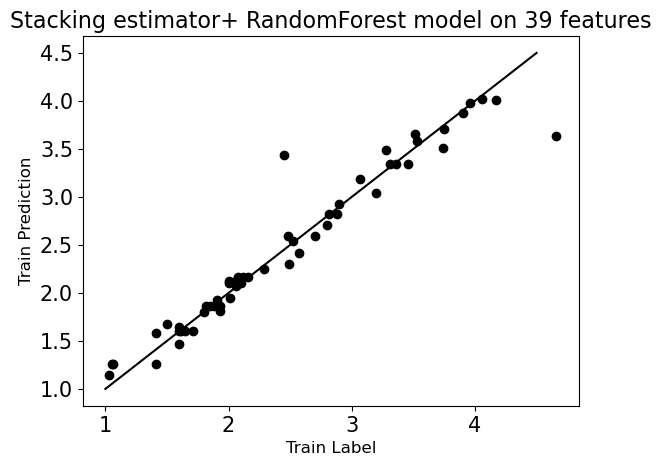

In [200]:
real_bandgap = []
results = []

exported_pipeline.fit(X, y.ravel())
test_lbl_pred = exported_pipeline.predict(X)

plt.scatter(y, test_lbl_pred, color="black")
plt.plot([1, 4.5], [1, 4.5], 'k-')
plt.xlabel('Train Label', fontsize = 12)
plt.ylabel('Train Prediction', fontsize = 12)
plt.title(str(Model)+' on '+ str(X.shape[1]) +' features', fontsize = 16)
print("Mean squared error: %.3f" % mean_squared_error(y, test_lbl_pred))
print("Median absolute error: %.3f" % median_absolute_error(y, test_lbl_pred))
print("Coefficient of determination: %.3f" % r2_score(y, test_lbl_pred))
del[[X, y, exported_pipeline, test_lbl_pred, real_bandgap, results]]

the same but without 0 features:

In [176]:
%%time

import tpot
from tpot import TPOTRegressor
from sklearn.model_selection import train_test_split

X = master_database_wo_duplicates.iloc[:, 86:-1].loc[:, (master_database_wo_duplicates.iloc[:, 86:-1] != 0).any(axis=0)].to_numpy()
y = np.array(Bandgap_54x)

tpot = TPOTRegressor(generations=10, population_size=50, verbosity=3, random_state=42,
                     config_dict=tpot_config,
                     cv=LeaveOneOut())

tpot.fit(X, y)
print(tpot.score(X, y))
tpot.export('tpot-weight-30-weight-features.py')

30 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/550 [00:00<?, ?pipeline/s]

_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(48, 0)) while a minimum of 1 is required..
_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(48, 0)) while a minimum of 1 is required..
_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(48, 0)) while a minimum of 1 is required..

Generation 1 - Current Pareto front scores:

-1	-0.5519467929418914	XGBRegressor(input_matrix, XGBRegressor__learning_rate=0.1, XGBRegressor__max_depth=8, XGBRegressor__min_child_weight=3, XGBRegressor__n_estimators=100, XGBRegressor__n_jobs=1, XGBRegressor__objective=reg:squarederror, XGBRegressor__subsample=0.4, XGBRegressor__verbosity=0)

-2	-0.5081942321989453	RandomForestRegressor(Normalizer(input_matrix, Normalizer__norm=l1), RandomForestRegressor__bootstrap=False, RandomForestRegressor__max_features=0.9000000000000001, RandomForestRegressor__min_samples_leaf=1, Rand

_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(48, 0)) while a minimum of 1 is required..
_pre_test decorator: _random_mutation_operator: num_test=1 Found array with 0 feature(s) (shape=(48, 0)) while a minimum of 1 is required..

Generation 9 - Current Pareto front scores:

-1	-0.5081942321989453	RandomForestRegressor(input_matrix, RandomForestRegressor__bootstrap=False, RandomForestRegressor__max_features=0.9000000000000001, RandomForestRegressor__min_samples_leaf=1, RandomForestRegressor__min_samples_split=8, RandomForestRegressor__n_estimators=100)

-2	-0.49518075371522674	AdaBoostRegressor(Binarizer(input_matrix, Binarizer__threshold=0.05), AdaBoostRegressor__learning_rate=1.0, AdaBoostRegressor__loss=linear, AdaBoostRegressor__n_estimators=100)

-3	-0.4727832326902392	AdaBoostRegressor(XGBRegressor(Binarizer(input_matrix, Binarizer__threshold=0.05), XGBRegressor__learning_rate=0.5, XGBRegressor__max_depth=6, XGBRegressor__min_chil

Mean squared error: 0.47
Median absolute error: 0.40
Coefficient of determination: 0.39


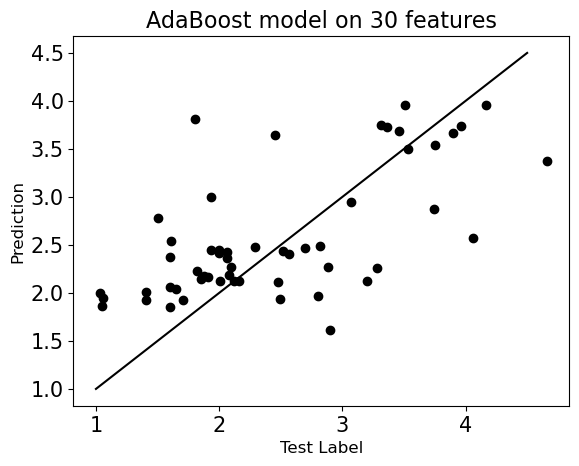

In [195]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import Binarizer
from tpot.builtins import StackingEstimator
from xgboost import XGBRegressor
from tpot.export_utils import set_param_recursive

# Average CV score on the training set was: -0.4727832326902392
exported_pipeline = make_pipeline(
    Binarizer(threshold=0.05),
    StackingEstimator(estimator=XGBRegressor(learning_rate=0.5, max_depth=6, min_child_weight=6, n_estimators=100, n_jobs=1, objective="reg:squarederror", subsample=0.3, verbosity=0)),
    AdaBoostRegressor(learning_rate=0.5, loss="square", n_estimators=100)
)
set_param_recursive(exported_pipeline.steps, 'random_state', 42)


loo = LeaveOneOut()
X = master_database_wo_duplicates.iloc[:, 86:-1].loc[:, (master_database_wo_duplicates.iloc[:, 86:-1] != 0).any(axis=0)].to_numpy()
y = np.array(Bandgap_54x)

real_bandgap = []
results = []
Model = 'AdaBoost model'

for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    exported_pipeline.fit(X_train, y_train.ravel())
    test_lbl_pred = exported_pipeline.predict(X_test)

    real_bandgap.append(y_test)
    results.append(test_lbl_pred[0])
    #print(y_test)
    #print(test_lbl_pred[0])

# Plot outputs
plt.scatter(real_bandgap, results, color="black")
plt.plot([1, 4.5], [1, 4.5], 'k-')
plt.xlabel('Test Label', fontsize = 12)
plt.ylabel('Prediction', fontsize = 12)
plt.title(str(Model)+' on '+ str(X.shape[1]) +' features', fontsize = 16)
print("Mean squared error: %.2f" % mean_squared_error(real_bandgap, results))
print("Median absolute error: %.2f" % median_absolute_error(real_bandgap, results))
print("Coefficient of determination: %.2f" % r2_score(real_bandgap, results))
del[[real_bandgap, results]]

Mean squared error: 0.12
Median absolute error: 0.28
Coefficient of determination: 0.85


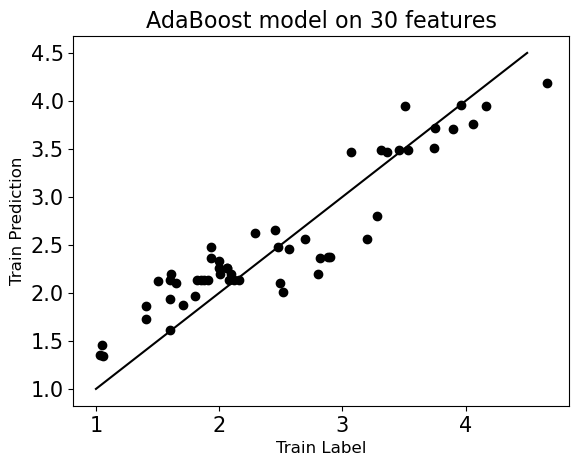

In [196]:
real_bandgap = []
results = []

exported_pipeline.fit(X, y.ravel())
test_lbl_pred = exported_pipeline.predict(X)

plt.scatter(y, test_lbl_pred, color="black")
plt.plot([1, 4.5], [1, 4.5], 'k-')
plt.xlabel('Train Label', fontsize = 12)
plt.ylabel('Train Prediction', fontsize = 12)
plt.title(str(Model)+' on '+ str(X.shape[1]) +' features', fontsize = 16)
print("Mean squared error: %.2f" % mean_squared_error(y, test_lbl_pred))
print("Median absolute error: %.2f" % median_absolute_error(y, test_lbl_pred))
print("Coefficient of determination: %.2f" % r2_score(y, test_lbl_pred))
del[[X, y, exported_pipeline, test_lbl_pred, real_bandgap, results]]

if I try the model optimized on also 0s features:

Mean squared error: 0.45
Median absolute error: 0.34
Coefficient of determination: 0.43


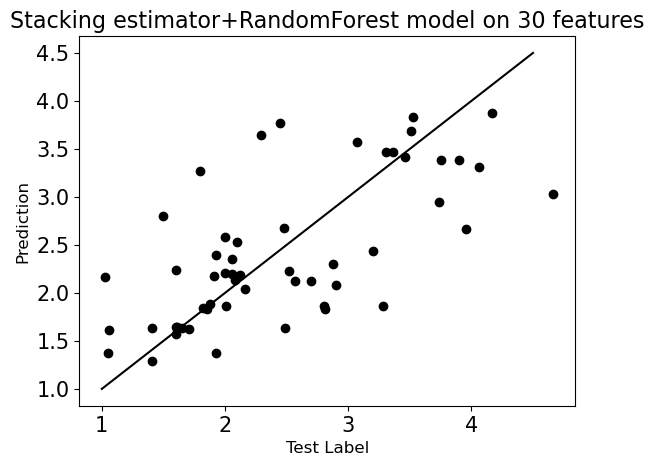

In [193]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator
from tpot.export_utils import set_param_recursive

exported_pipeline = make_pipeline(
    StackingEstimator(estimator=SGDRegressor(alpha=0.01, eta0=0.01, fit_intercept=True, l1_ratio=1.0, learning_rate="invscaling", loss="huber", penalty="elasticnet", power_t=0.1)),
    RandomForestRegressor(bootstrap=False, max_features=0.7500000000000001, min_samples_leaf=1, min_samples_split=6, n_estimators=100)
)

set_param_recursive(exported_pipeline.steps, 'random_state', 42)

loo = LeaveOneOut()
X = master_database_wo_duplicates.iloc[:, 86:-1].loc[:, (master_database_wo_duplicates.iloc[:, 86:-1] != 0).any(axis=0)].to_numpy()
y = np.array(Bandgap_54x)

real_bandgap = []
results = []
Model = 'Stacking estimator+RandomForest model'

for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    exported_pipeline.fit(X_train, y_train.ravel())
    test_lbl_pred = exported_pipeline.predict(X_test)

    real_bandgap.append(y_test)
    results.append(test_lbl_pred[0])
    #print(y_test)
    #print(test_lbl_pred[0])

# Plot outputs
plt.scatter(real_bandgap, results, color="black")
plt.plot([1, 4.5], [1, 4.5], 'k-')
plt.xlabel('Test Label', fontsize = 12)
plt.ylabel('Prediction', fontsize = 12)
plt.title(str(Model)+' on '+ str(X.shape[1]) +' features', fontsize = 16)
print("Mean squared error: %.2f" % mean_squared_error(real_bandgap, results))
print("Median absolute error: %.2f" % median_absolute_error(real_bandgap, results))
print("Coefficient of determination: %.2f" % r2_score(real_bandgap, results))
del[[real_bandgap, results]]

Mean squared error: 0.049
Median absolute error: 0.071
Coefficient of determination: 0.937


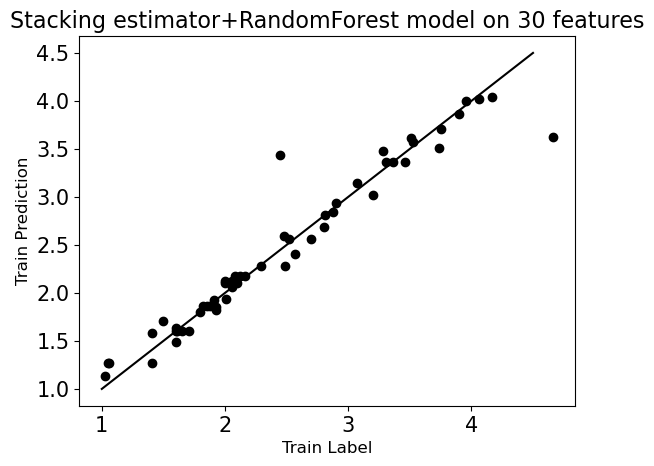

In [194]:
real_bandgap = []
results = []

X = master_database_wo_duplicates.iloc[:, 86:-1].loc[:, (master_database_wo_duplicates.iloc[:, 86:-1] != 0).any(axis=0)].to_numpy()
y = np.array(Bandgap_54x)

exported_pipeline.fit(X, y.ravel())
test_lbl_pred = exported_pipeline.predict(X)

plt.scatter(y, test_lbl_pred, color="black")
plt.plot([1, 4.5], [1, 4.5], 'k-')
plt.xlabel('Train Label', fontsize = 12)
plt.ylabel('Train Prediction', fontsize = 12)
plt.title(str(Model)+' on '+ str(X.shape[1]) +' features', fontsize = 16)
print("Mean squared error: %.3f" % mean_squared_error(y, test_lbl_pred))
print("Median absolute error: %.3f" % median_absolute_error(y, test_lbl_pred))
print("Coefficient of determination: %.3f" % r2_score(y, test_lbl_pred))
del[[X, y, exported_pipeline, test_lbl_pred, real_bandgap, results]]

# Tpot on elemental + weight comp + sample/crystal info

In [205]:
%%time

X = master_database_wo_duplicates.iloc[:, :-1].to_numpy()
y = np.array(Bandgap_54x)

tpot = TPOTRegressor(generations=10, population_size=50, verbosity=3, random_state=42,
                     config_dict=tpot_config,
                     cv=LeaveOneOut())

tpot.fit(X, y)
print(tpot.score(X, y))
tpot.export('tpot-full-search-125-features.py')

30 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/550 [00:00<?, ?pipeline/s]

_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(48, 0)) while a minimum of 1 is required..
_pre_test decorator: _random_mutation_operator: num_test=0 l1 was provided as affinity. Ward can only work with euclidean distances..
_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(48, 0)) while a minimum of 1 is required..
_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(48, 0)) while a minimum of 1 is required..
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.

Generation 1 - Current Pareto front scores:

-1	-0.3566675541761357	XGBRegressor(input_matrix, XGBRegressor__learning_rate=0.1, XGBRegressor__max_depth=8, XGBRegressor__min_ch

_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(48, 0)) while a minimum of 1 is required..
_pre_test decorator: _random_mutation_operator: num_test=0 l1 was provided as affinity. Ward can only work with euclidean distances..
_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 48, n_neighbors = 50.
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.

Generation 7 - Current Pareto front scores:

-1	-0.3566675541761357	XGBRegressor(input_matrix, XGBRegressor__learning_rate=0.1, XGBRegressor__max_depth=8, XGBRegressor__min_child_weight=3


Generation 9 - Current Pareto front scores:

-1	-0.3466308659968697	XGBRegressor(input_matrix, XGBRegressor__learning_rate=0.1, XGBRegressor__max_depth=6, XGBRegressor__min_child_weight=4, XGBRegressor__n_estimators=100, XGBRegressor__n_jobs=1, XGBRegressor__objective=reg:squarederror, XGBRegressor__subsample=0.5, XGBRegressor__verbosity=0)

-2	-0.30867520811187615	XGBRegressor(DecisionTreeRegressor(input_matrix, DecisionTreeRegressor__max_depth=8, DecisionTreeRegressor__min_samples_leaf=11, DecisionTreeRegressor__min_samples_split=19), XGBRegressor__learning_rate=0.1, XGBRegressor__max_depth=8, XGBRegressor__min_child_weight=3, XGBRegressor__n_estimators=100, XGBRegressor__n_jobs=1, XGBRegressor__objective=reg:squarederror, XGBRegressor__subsample=0.4, XGBRegressor__verbosity=0)

-3	-0.3047423141601286	XGBRegressor(VarianceThreshold(DecisionTreeRegressor(input_matrix, DecisionTreeRegressor__max_depth=5, DecisionTreeRegressor__min_samples_leaf=8, DecisionTreeRegressor__min_samples_spl

Mean squared error: 0.30
Median absolute error: 0.22
Coefficient of determination: 0.61


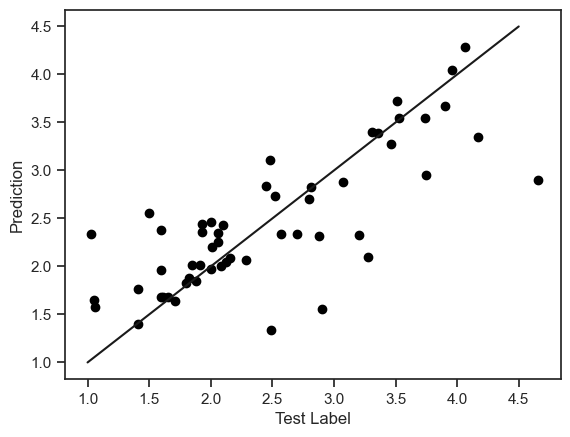

In [219]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from sklearn.tree import DecisionTreeRegressor
from tpot.builtins import StackingEstimator
from xgboost import XGBRegressor
from tpot.export_utils import set_param_recursive

# Average CV score on the training set was: -0.3047423141601286
exported_pipeline = make_pipeline(
    StackingEstimator(estimator=DecisionTreeRegressor(max_depth=5, min_samples_leaf=8, min_samples_split=13)),
    VarianceThreshold(threshold=0.2),
    XGBRegressor(learning_rate=0.1, max_depth=8, min_child_weight=3, n_estimators=100, n_jobs=1, objective="reg:squarederror", subsample=0.4, verbosity=0)
)
# Fix random state for all the steps in exported pipeline
set_param_recursive(exported_pipeline.steps, 'random_state', 42)

loo = LeaveOneOut()
X = master_database_wo_duplicates.iloc[:, :-1].to_numpy()
y = np.array(Bandgap_54x)

real_bandgap = []
results = []
Model = 'StackingEstimator/DecisionTreeRegressor+VarianceThreshold+XGBRegressor'

for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    exported_pipeline.fit(X_train, y_train.ravel())
    test_lbl_pred = exported_pipeline.predict(X_test)

    real_bandgap.append(y_test)
    results.append(test_lbl_pred[0])
    #print(y_test)
    #print(test_lbl_pred[0])

# Plot outputs
plt.scatter(real_bandgap, results, color="black")
plt.plot([1, 4.5], [1, 4.5], 'k-')
plt.xlabel('Test Label', fontsize = 12)
plt.ylabel('Prediction', fontsize = 12)
#plt.title(str(Model)+' on '+ str(X.shape[1]) +' features', fontsize = 16)
print("Mean squared error: %.2f" % mean_squared_error(real_bandgap, results))
print("Median absolute error: %.2f" % median_absolute_error(real_bandgap, results))
print("Coefficient of determination: %.2f" % r2_score(real_bandgap, results))
del[[real_bandgap, results]]

Mean squared error: 0.03
Median absolute error: 0.06
Coefficient of determination: 0.96


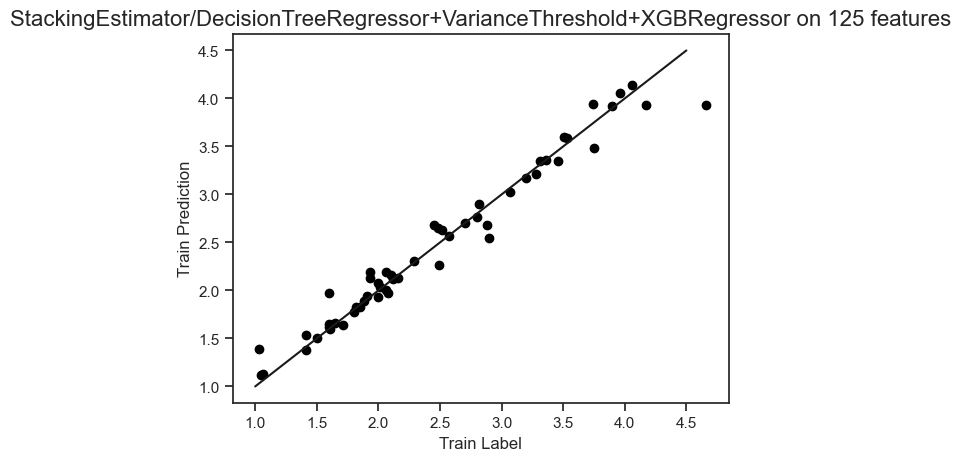

In [220]:
# Average CV score on the training set was: -0.3047423141601286
exported_pipeline = make_pipeline(
    StackingEstimator(estimator=DecisionTreeRegressor(max_depth=5, min_samples_leaf=8, min_samples_split=13)),
    VarianceThreshold(threshold=0.2),
    XGBRegressor(learning_rate=0.1, max_depth=8, min_child_weight=3, n_estimators=100, n_jobs=1, objective="reg:squarederror", subsample=0.4, verbosity=0)
)
# Fix random state for all the steps in exported pipeline
set_param_recursive(exported_pipeline.steps, 'random_state', 42)

real_bandgap = []
results = []

exported_pipeline.fit(X, y.ravel())
test_lbl_pred = exported_pipeline.predict(X)

plt.scatter(y, test_lbl_pred, color="black")
plt.plot([1, 4.5], [1, 4.5], 'k-')
plt.xlabel('Train Label', fontsize = 12)
plt.ylabel('Train Prediction', fontsize = 12)
plt.title(str(Model)+' on '+ str(X.shape[1]) +' features', fontsize = 16)
print("Mean squared error: %.2f" % mean_squared_error(y, test_lbl_pred))
print("Median absolute error: %.2f" % median_absolute_error(y, test_lbl_pred))
print("Coefficient of determination: %.2f" % r2_score(y, test_lbl_pred))
del[[X, y, exported_pipeline, test_lbl_pred, real_bandgap, results]]

# PCA analysis

In [126]:
master_database_wo_duplicates.iloc[:, :64].columns

Index(['ionic_radii_A1', 'ideal_X-O_bond_A1', 'electronegativity_A1',
       'vdW_radius_A1', 'ionization_E_A1', 'Molar_V_A1', 'Atomic_#_A1',
       'Atomic_mass_A1', 'ionic_radii_A2', 'ideal_X-O_bond_A2',
       'electronegativity_A2', 'vdW_radius_A2', 'ionization_E_A2',
       'Molar_V_A2', 'Atomic_#_A2', 'Atomic_mass_A2', 'ionic_radii_B1',
       'ideal_X-O_bond_B1', 'electronegativity_B1', 'vdW_radius_B1',
       'ionization_E_B1', 'Molar_V_B1', 'Atomic_#_B1', 'Atomic_mass_B1',
       'ionic_radii_B2', 'ideal_X-O_bond_B2', 'electronegativity_B2',
       'vdW_radius_B2', 'ionization_E_B2', 'Molar_V_B2', 'Atomic_#_B2',
       'Atomic_mass_B2', 'ionic_radii_A1/B1', 'ideal_X-O_bond_A1/B1',
       'electronegativity_A1/B1', 'vdW_radius_A1/B1', 'ionization_E_A1/B1',
       'Molar_V_A1/B1', 'Atomic_#_A1/B1', 'Atomic_mass_A1/B1',
       'ionic_radii_A1*B1', 'ideal_X-O_bond_A1*B1', 'electronegativity_A1*B1',
       'vdW_radius_A1*B1', 'ionization_E_A1*B1', 'Molar_V_A1*B1',
       'Atomic_#_

In [142]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(StandardScaler().fit_transform(master_database_wo_duplicates.iloc[:, :32]))
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

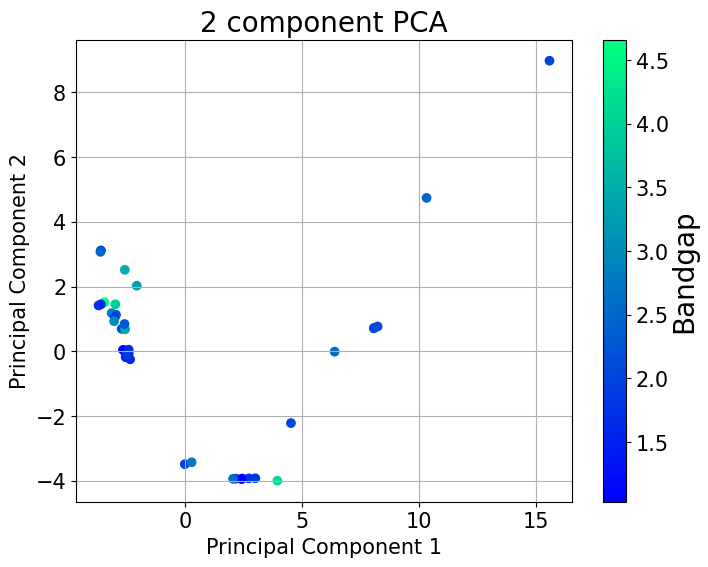

In [143]:
finalDf = pd.concat([principalDf, Bandgap_54x], axis = 1)
fig = plt.figure(figsize = (8,6)); marker_size=15
plt.scatter(finalDf['principal component 1'], finalDf['principal component 2'], c=finalDf['Bandgap'],
            cmap=matplotlib.colormaps['winter'])
plt.title('2 component PCA', fontsize = 20)
plt.xlabel('Principal Component 1', fontsize = 15); plt.ylabel('Principal Component 2', fontsize = 15); plt.grid()
cbar= plt.colorbar(); cbar.set_label("Bandgap", labelpad=+1, size=20); plt.show()
del[[finalDf, fig, cbar]]

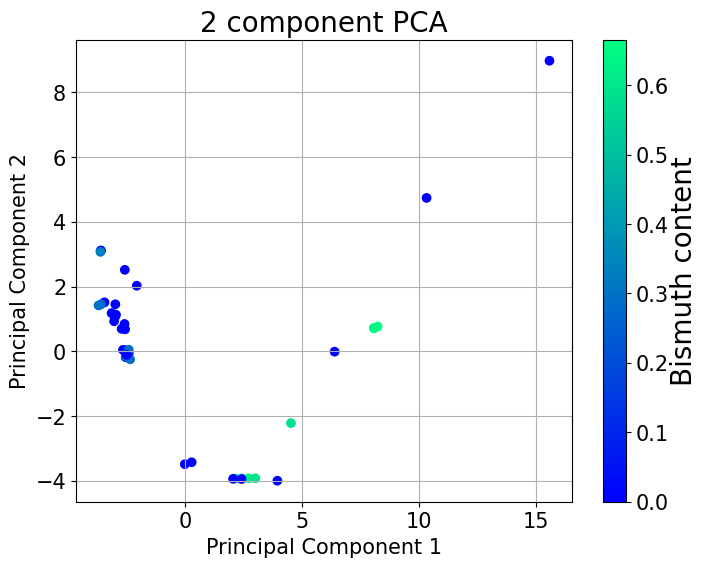

In [144]:
finalDf = pd.concat([principalDf, master_database_wo_duplicates['Bi']], axis = 1)
fig = plt.figure(figsize = (8,6)); marker_size=15
plt.scatter(finalDf['principal component 1'], finalDf['principal component 2'], c=finalDf['Bi'],
            cmap=matplotlib.colormaps['winter'])
plt.title('2 component PCA', fontsize = 20)
plt.xlabel('Principal Component 1', fontsize = 15); plt.ylabel('Principal Component 2', fontsize = 15); plt.grid()
cbar= plt.colorbar(); cbar.set_label("Bismuth content", labelpad=+1, size=20); plt.show()
del[[finalDf, fig, cbar]]

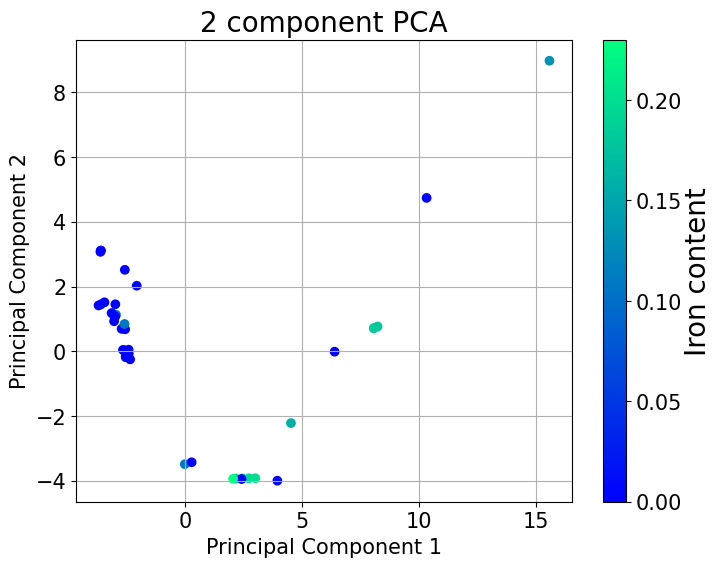

In [145]:
finalDf = pd.concat([principalDf, master_database_wo_duplicates['Fe']], axis = 1)
fig = plt.figure(figsize = (8,6)); marker_size=15
plt.scatter(finalDf['principal component 1'], finalDf['principal component 2'], c=finalDf['Fe'],
            cmap=matplotlib.colormaps['winter'])
plt.title('2 component PCA', fontsize = 20)
plt.xlabel('Principal Component 1', fontsize = 15); plt.ylabel('Principal Component 2', fontsize = 15); plt.grid()
cbar= plt.colorbar(); cbar.set_label("Iron content", labelpad=+1, size=20); plt.show()
del[[finalDf, fig, cbar]]

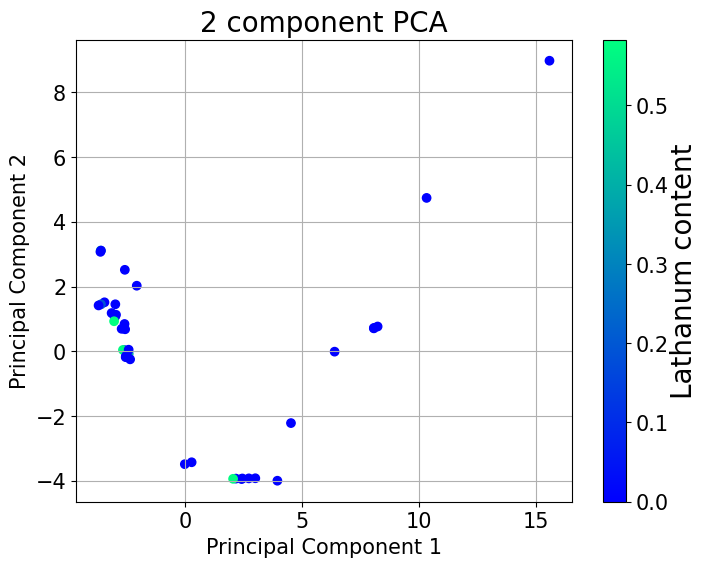

In [146]:
finalDf = pd.concat([principalDf, master_database_wo_duplicates['La']], axis = 1)
fig = plt.figure(figsize = (8,6)); marker_size=15
plt.scatter(finalDf['principal component 1'], finalDf['principal component 2'], c=finalDf['La'],
            cmap=matplotlib.colormaps['winter'])
plt.title('2 component PCA', fontsize = 20)
plt.xlabel('Principal Component 1', fontsize = 15); plt.ylabel('Principal Component 2', fontsize = 15); plt.grid()
cbar= plt.colorbar(); cbar.set_label("Lathanum content", labelpad=+1, size=20); plt.show()
del[[finalDf, fig, cbar]]

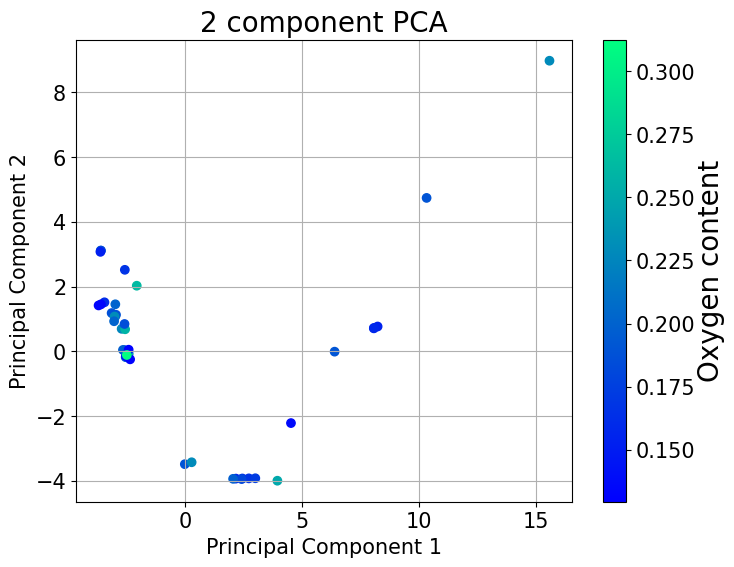

In [147]:
finalDf = pd.concat([principalDf, master_database_wo_duplicates['O']], axis = 1)
fig = plt.figure(figsize = (8,6)); marker_size=15
plt.scatter(finalDf['principal component 1'], finalDf['principal component 2'], c=finalDf['O'],
            cmap=matplotlib.colormaps['winter'])
plt.title('2 component PCA', fontsize = 20)
plt.xlabel('Principal Component 1', fontsize = 15); plt.ylabel('Principal Component 2', fontsize = 15); plt.grid()
cbar= plt.colorbar(); cbar.set_label("Oxygen content", labelpad=+1, size=20); plt.show()
del[[finalDf, fig, cbar]]

In [148]:
principalComponents.shape

(54, 2)

In [140]:
pca.n_components_

2

# WAE

In [163]:
#import cv2
import os
import time
import random
import numpy as np
import pandas as pd
#!pip install torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, lr_scheduler
from torch.utils.data import Dataset, DataLoader
from scipy.spatial.distance import cdist
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Ellipse
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

sns.set(color_codes=True)

In [164]:
# -*- coding: utf-8 -*-
"""
Created on Fri Feb 25 18:19:04 2022
https://github.com/ziyuanrao11/Machine-learning-enabled-high-entropy-alloy-discovery
@author: p.tung; z.rao
"""


class FeatureDataset(Dataset): #from numpy to tensor (pytroch-readable)
    '''
    Args: x is a 2D numpy array [x_size, x_features]
    '''
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def __len__(self):
        return self.x.shape[0]
    
    def __getitem__(self, idx):
        return torch.FloatTensor(self.x[idx]), torch.FloatTensor(self.y[idx])
    
class AttributeDataset(Dataset): # this is for classifier 
    '''
    Args: x is a 2D numpy array [x_size, x_features]
    '''
    def __init__(self, x, y):
        self.x = x
        self.y = y
    def __len__(self):
        return self.x.shape[0]
    def __getitem__(self, idx):
        return torch.Tensor(self.x[idx]), torch.Tensor(self.y[idx])

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)
        
def same_seeds(seed): #fix np & torch seed to the same.
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

def get_latents(model, dataset): #from dataset to altten
    model.to(device).eval() # training model or evaluation mode, eval means setting the model to its evaluation mode (gradient fixed)
    latents = []
    with torch.no_grad(): # fix the gradient, assure that the model parameters are fixed
        dataloader = DataLoader(dataset, batch_size=256, shuffle=False)
        for i, data in enumerate(dataloader):
            x = data[0].to(device)
            recon_x, z = model(x)
            latents.append(z.detach().cpu().numpy())
    return np.concatenate(latents,axis=0)

def imq_kernel(X: torch.Tensor, Y: torch.Tensor, h_dim: int): # common kerntl to choose
    batch_size = X.size(0)

    norms_x = X.pow(2).sum(1, keepdim=True)  # batch_size x 1
    prods_x = torch.mm(X, X.t()).to(device)  # batch_size x batch_size
    dists_x = norms_x + norms_x.t() - 2 * prods_x # mm matrix multiplicaiton

    norms_y = Y.pow(2).sum(1, keepdim=True).to(device)  # batch_size x 1
    prods_y = torch.mm(Y, Y.t()).to(device)  # batch_size x batch_size
    dists_y = norms_y + norms_y.t() - 2 * prods_y

    dot_prd = torch.mm(X, Y.t())
    dists_c = norms_x + norms_y.t() - 2 * dot_prd

    stats = 0
    for scale in [.1, .2, .5, 1., 2., 5., 10.]: # need more study on this
        C = 2 * h_dim * 1.0 * scale
        res1 = C / (C + dists_x)
        res1 += C / (C + dists_y)

        if torch.cuda.is_available():
            res1 = (1 - torch.eye(batch_size).to(device)) * res1
        else:
            res1 = (1 - torch.eye(batch_size)) * res1

        res1 = res1.sum() / (batch_size - 1)
        res2 = C / (C + dists_c)
        res2 = res2.sum() * 2. / (batch_size)
        stats += res1 - res2

    return stats
#plotting functions
def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gm, X, label=True, ax=None):
    X= latents
    fig, axs = plt.subplots(1,1,figsize=(2,2),dpi=200)
    ax = axs or plt.gca()
    labels = gm.fit(X).predict(X)
    if label:
        low_cu = raw_x[:,5] < 0.05
        low_cu_latent = latents[low_cu]
        low_cu_color = raw_y[:][low_cu]

        high_cu = raw_x[:,5] >= 0.05
        high_cu_latent = latents[high_cu]
        high_cu_color = raw_y[:][high_cu]

        scatter1 = axs.scatter(low_cu_latent[:,0], low_cu_latent[:,1], c=low_cu_color, alpha=.65, s=8, linewidths=0, cmap='viridis')
        scatter2 = axs.scatter(high_cu_latent[:,0], high_cu_latent[:,1], c=high_cu_color, alpha=.65, s=14, linewidths=0, cmap='Reds', marker='^')
        #scatter3 = axs.scatter(latents[698:,0], latents[698:,1], alpha=1., s=10, linewidths=.75, edgecolors='k', facecolors='none')
    else:
        ax.scatter(X[:, 0], X[:, 1], s=5, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gm.weights_.max()
    for pos, covar, w in zip(gm.means_, gm.covariances_, gm.weights_):
        draw_ellipse(pos, covar, alpha= 0.75*w * w_factor, facecolor='slategrey', zorder=-10)

In [165]:
# -*- coding: utf-8 -*-
"""
https://github.com/ziyuanrao11/Machine-learning-enabled-high-entropy-alloy-discovery
"""
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
root = '/Users/hostas/Documents/01-Analysis/2022-11-06 Perovskites/'

class WAE(nn.Module):
    def __init__(self, input_size):
        super(WAE, self).__init__()
        self.input_size = input_size

        # encoder
        self.encoder = nn.Sequential(
                        nn.Linear(self.input_size, 64), # was 80
                        nn.LayerNorm(64),
                        nn.ReLU(),
                        nn.Linear(64, 48),
                        nn.LayerNorm(48),
                        nn.ReLU(),
                        nn.Linear(48, 24),
                        nn.LayerNorm(24),
                        nn.ReLU(),
                        nn.Linear(24, 2),
                        )

        # decoder
        self.decoder = nn.Sequential(
                        nn.Linear(2, 24),
                        nn.LayerNorm(24),
                        nn.ReLU(),
                        nn.Linear(24, 48),
                        nn.LayerNorm(48),
                        nn.ReLU(),
                        nn.Linear(48, 64),
                        nn.LayerNorm(64),
                        nn.ReLU(),
                        nn.Linear(64, self.input_size), # was 80
                        nn.Softmax(dim=1) #(softmad along dimension 1)
                        )
        self.apply(weights_init)
    
    def forward(self, x):
        z = self._encode(x)
        x_recon = self._decode(z)

        return x_recon, z
    
    def _encode(self, x):
        return self.encoder(x)

    def _decode(self, z):
        return self.decoder(z)
#%% Data loading, params - here you can play around with all different combinations of paramters to reduce the total loss. You can visualize your training history just to see how good your chosen set of hyperparameters performs 

In [167]:
master_database_wo_duplicates.iloc[:, :64].columns

Index(['ionic_radii_A1', 'ideal_X-O_bond_A1', 'electronegativity_A1',
       'vdW_radius_A1', 'ionization_E_A1', 'Molar_V_A1', 'Atomic_#_A1',
       'Atomic_mass_A1', 'ionic_radii_A2', 'ideal_X-O_bond_A2',
       'electronegativity_A2', 'vdW_radius_A2', 'ionization_E_A2',
       'Molar_V_A2', 'Atomic_#_A2', 'Atomic_mass_A2', 'ionic_radii_B1',
       'ideal_X-O_bond_B1', 'electronegativity_B1', 'vdW_radius_B1',
       'ionization_E_B1', 'Molar_V_B1', 'Atomic_#_B1', 'Atomic_mass_B1',
       'ionic_radii_B2', 'ideal_X-O_bond_B2', 'electronegativity_B2',
       'vdW_radius_B2', 'ionization_E_B2', 'Molar_V_B2', 'Atomic_#_B2',
       'Atomic_mass_B2', 'ionic_radii_A1/B1', 'ideal_X-O_bond_A1/B1',
       'electronegativity_A1/B1', 'vdW_radius_A1/B1', 'ionization_E_A1/B1',
       'Molar_V_A1/B1', 'Atomic_#_A1/B1', 'Atomic_mass_A1/B1',
       'ionic_radii_A1*B1', 'ideal_X-O_bond_A1*B1', 'electronegativity_A1*B1',
       'vdW_radius_A1*B1', 'ionization_E_A1*B1', 'Molar_V_A1*B1',
       'Atomic_#_

In [174]:
# all = pd.read_csv('data_base.csv', header=0).iloc[:,1:19].to_numpy()
# raw_x = all[:696,:6]
# raw_y = all[:696,17].reshape(-1,1)
# dataset = FeatureDataset(raw_x[:], raw_y[:]) #numpy to tensor

raw_x = StandardScaler().fit_transform(master_database_wo_duplicates.iloc[:, :64]) # puvodne [0:696,:6]
raw_y = np.array(Bandgap_54x).reshape(-1,1) # puvodne [0:696,:6]

def train_WAE(model, optimizer, dataloader, params):    
    model_name = params['model_name']
    num_epoch = params['num_epoch']
    sigma = params['sigma'] # assuming the latent space follows Gaussian
    MMD_lambda = params['MMD_lambda'] #WAE distance (maximum mean discrepancy)

    folder_dir = os.path.join(root, model_name) # a folder to save models
    if not os.path.isdir(folder_dir):
        os.mkdir(folder_dir)
    loss_=[]   
    for epoch in range(num_epoch):
        start_time = time.time()
        total_loss = [] #save for plot, recon loss+MMD
        total_recon = [] # binary cross entropy
        total_MMD = [] #maximum mean discrepancy
        
        for i, data in enumerate(dataloader):
            x = data[0].to(device)
            y = data[1].to(device)
            model.train() # model goes to train mode
            recon_x, z_tilde = model(x) # latent space is Z_tilde
            z = sigma*torch.randn(z_tilde.size()).to(device) # z is sampled from a Gaussian that has the same dimension (but no relation to z_tilde).

            #recon_loss = F.binary_cross_entropy(recon_x, x, reduction='mean') #lowest reconstruction loss 
            recon_loss = F.mse_loss(recon_x, x, reduction='mean') 
            #recon_loss = F.l1_loss(recon_x, x, reduction='mean')
            
            MMD_loss = imq_kernel(z_tilde, z, h_dim=2).to(device) #W-distance between z_tilde and z
            MMD_loss = MMD_loss / x.size(0) #averaging, because recon loss is mean.
            loss = recon_loss + MMD_loss * MMD_lambda #MM_lambda: learning-rate alike, hyperparamer

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss.append(loss.item())# from tensor to values
            total_recon.append(recon_loss.item())
            total_MMD.append(MMD_loss.item())

        avg_loss = sum(total_loss)/len(total_loss)
        avg_recon = sum(total_recon)/len(total_recon)
        avg_MMD = sum(total_MMD)/len(total_MMD)
        loss_.append(avg_loss)

        #scheduler.step(avg_loss)

        print('[{:03}/{:03}] loss: {:.6f} Recon_loss: {:.6f}, MMD_loss:{:.6f}, time: {:.3f} sec'.format(\
                                        epoch+1, num_epoch, \
                                        avg_loss, \
                                        avg_recon, avg_MMD, time.time() - start_time))
        # save the model every 5 epoches
        if (epoch+1) % 5 == 0:
            save_model_dir = str(model_name + "_{}.pth".format(epoch+1))
            torch.save(model.state_dict(), os.path.join(folder_dir, save_model_dir))
    return loss_

[001/2000] loss: 0.958759 Recon_loss: 0.958277, MMD_loss:4.822774, time: 0.026 sec
[002/2000] loss: 0.981225 Recon_loss: 0.980725, MMD_loss:4.995987, time: 0.021 sec
[003/2000] loss: 1.317711 Recon_loss: 1.317287, MMD_loss:4.242767, time: 0.016 sec
[004/2000] loss: 0.979725 Recon_loss: 0.979229, MMD_loss:4.966782, time: 0.013 sec
[005/2000] loss: 0.971722 Recon_loss: 0.971259, MMD_loss:4.629169, time: 0.011 sec
[006/2000] loss: 0.966977 Recon_loss: 0.966553, MMD_loss:4.242187, time: 0.011 sec
[007/2000] loss: 1.017793 Recon_loss: 1.017312, MMD_loss:4.817630, time: 0.011 sec
[008/2000] loss: 0.948059 Recon_loss: 0.947585, MMD_loss:4.742609, time: 0.011 sec
[009/2000] loss: 0.943858 Recon_loss: 0.943408, MMD_loss:4.496505, time: 0.011 sec
[010/2000] loss: 1.028186 Recon_loss: 1.027730, MMD_loss:4.559713, time: 0.011 sec
[011/2000] loss: 1.033472 Recon_loss: 1.033035, MMD_loss:4.377245, time: 0.011 sec
[012/2000] loss: 0.966934 Recon_loss: 0.966464, MMD_loss:4.694388, time: 0.011 sec
[013

[112/2000] loss: 0.961690 Recon_loss: 0.961208, MMD_loss:4.822215, time: 0.012 sec
[113/2000] loss: 0.977927 Recon_loss: 0.977473, MMD_loss:4.539592, time: 0.012 sec
[114/2000] loss: 0.952016 Recon_loss: 0.951495, MMD_loss:5.208240, time: 0.013 sec
[115/2000] loss: 1.112930 Recon_loss: 1.112485, MMD_loss:4.448508, time: 0.013 sec
[116/2000] loss: 0.953191 Recon_loss: 0.952696, MMD_loss:4.947896, time: 0.013 sec
[117/2000] loss: 0.959342 Recon_loss: 0.958889, MMD_loss:4.533553, time: 0.012 sec
[118/2000] loss: 0.949684 Recon_loss: 0.949244, MMD_loss:4.408845, time: 0.011 sec
[119/2000] loss: 1.179344 Recon_loss: 1.178883, MMD_loss:4.612841, time: 0.011 sec
[120/2000] loss: 0.958516 Recon_loss: 0.958046, MMD_loss:4.699050, time: 0.012 sec
[121/2000] loss: 0.971214 Recon_loss: 0.970740, MMD_loss:4.741755, time: 0.013 sec
[122/2000] loss: 0.955887 Recon_loss: 0.955465, MMD_loss:4.217206, time: 0.012 sec
[123/2000] loss: 0.956495 Recon_loss: 0.956031, MMD_loss:4.635854, time: 0.011 sec
[124

[225/2000] loss: 0.953396 Recon_loss: 0.952912, MMD_loss:4.842208, time: 0.011 sec
[226/2000] loss: 0.955608 Recon_loss: 0.955167, MMD_loss:4.408682, time: 0.011 sec
[227/2000] loss: 0.988067 Recon_loss: 0.987650, MMD_loss:4.169908, time: 0.011 sec
[228/2000] loss: 1.000188 Recon_loss: 0.999726, MMD_loss:4.621310, time: 0.011 sec
[229/2000] loss: 0.958227 Recon_loss: 0.957813, MMD_loss:4.145457, time: 0.011 sec
[230/2000] loss: 1.120273 Recon_loss: 1.119777, MMD_loss:4.964581, time: 0.011 sec
[231/2000] loss: 1.127136 Recon_loss: 1.126674, MMD_loss:4.617211, time: 0.011 sec
[232/2000] loss: 0.956850 Recon_loss: 0.956393, MMD_loss:4.573273, time: 0.011 sec
[233/2000] loss: 0.973232 Recon_loss: 0.972758, MMD_loss:4.746075, time: 0.011 sec
[234/2000] loss: 0.962667 Recon_loss: 0.962206, MMD_loss:4.613318, time: 0.011 sec
[235/2000] loss: 0.935138 Recon_loss: 0.934671, MMD_loss:4.666867, time: 0.011 sec
[236/2000] loss: 0.949168 Recon_loss: 0.948718, MMD_loss:4.508806, time: 0.011 sec
[237

[339/2000] loss: 1.009280 Recon_loss: 1.008808, MMD_loss:4.720235, time: 0.011 sec
[340/2000] loss: 0.961636 Recon_loss: 0.961156, MMD_loss:4.796455, time: 0.011 sec
[341/2000] loss: 0.968534 Recon_loss: 0.968062, MMD_loss:4.710721, time: 0.011 sec
[342/2000] loss: 0.952075 Recon_loss: 0.951640, MMD_loss:4.352883, time: 0.011 sec
[343/2000] loss: 1.026987 Recon_loss: 1.026519, MMD_loss:4.685235, time: 0.011 sec
[344/2000] loss: 1.092082 Recon_loss: 1.091628, MMD_loss:4.545299, time: 0.011 sec
[345/2000] loss: 0.969770 Recon_loss: 0.969295, MMD_loss:4.751336, time: 0.011 sec
[346/2000] loss: 0.984172 Recon_loss: 0.983729, MMD_loss:4.432870, time: 0.011 sec
[347/2000] loss: 0.961812 Recon_loss: 0.961334, MMD_loss:4.783848, time: 0.011 sec
[348/2000] loss: 1.118181 Recon_loss: 1.117705, MMD_loss:4.760059, time: 0.011 sec
[349/2000] loss: 1.127729 Recon_loss: 1.127275, MMD_loss:4.545117, time: 0.011 sec
[350/2000] loss: 0.956601 Recon_loss: 0.956150, MMD_loss:4.504506, time: 0.011 sec
[351

[453/2000] loss: 0.958070 Recon_loss: 0.957602, MMD_loss:4.682189, time: 0.011 sec
[454/2000] loss: 1.098879 Recon_loss: 1.098408, MMD_loss:4.709400, time: 0.011 sec
[455/2000] loss: 0.935017 Recon_loss: 0.934531, MMD_loss:4.862624, time: 0.011 sec
[456/2000] loss: 0.940954 Recon_loss: 0.940487, MMD_loss:4.661202, time: 0.011 sec
[457/2000] loss: 0.935293 Recon_loss: 0.934830, MMD_loss:4.623436, time: 0.011 sec
[458/2000] loss: 0.930170 Recon_loss: 0.929725, MMD_loss:4.444864, time: 0.011 sec
[459/2000] loss: 1.015415 Recon_loss: 1.014957, MMD_loss:4.579718, time: 0.011 sec
[460/2000] loss: 0.962110 Recon_loss: 0.961661, MMD_loss:4.486699, time: 0.011 sec
[461/2000] loss: 0.969689 Recon_loss: 0.969157, MMD_loss:5.316325, time: 0.011 sec
[462/2000] loss: 0.936410 Recon_loss: 0.935948, MMD_loss:4.618568, time: 0.011 sec
[463/2000] loss: 0.938370 Recon_loss: 0.937903, MMD_loss:4.663071, time: 0.011 sec
[464/2000] loss: 0.965052 Recon_loss: 0.964597, MMD_loss:4.543605, time: 0.011 sec
[465

[567/2000] loss: 1.132465 Recon_loss: 1.132031, MMD_loss:4.344426, time: 0.011 sec
[568/2000] loss: 0.930421 Recon_loss: 0.929946, MMD_loss:4.751618, time: 0.011 sec
[569/2000] loss: 1.107095 Recon_loss: 1.106609, MMD_loss:4.857630, time: 0.011 sec
[570/2000] loss: 1.117436 Recon_loss: 1.116980, MMD_loss:4.560578, time: 0.011 sec
[571/2000] loss: 1.027480 Recon_loss: 1.027029, MMD_loss:4.507676, time: 0.011 sec
[572/2000] loss: 0.947813 Recon_loss: 0.947361, MMD_loss:4.520603, time: 0.011 sec
[573/2000] loss: 0.975128 Recon_loss: 0.974689, MMD_loss:4.391000, time: 0.011 sec
[574/2000] loss: 1.031864 Recon_loss: 1.031411, MMD_loss:4.538038, time: 0.011 sec
[575/2000] loss: 0.957390 Recon_loss: 0.956954, MMD_loss:4.358837, time: 0.011 sec
[576/2000] loss: 0.962523 Recon_loss: 0.962055, MMD_loss:4.677343, time: 0.011 sec
[577/2000] loss: 0.946290 Recon_loss: 0.945805, MMD_loss:4.848152, time: 0.011 sec
[578/2000] loss: 0.976717 Recon_loss: 0.976334, MMD_loss:3.827054, time: 0.011 sec
[579

[681/2000] loss: 1.058338 Recon_loss: 1.057809, MMD_loss:5.286599, time: 0.012 sec
[682/2000] loss: 0.968611 Recon_loss: 0.968135, MMD_loss:4.757859, time: 0.011 sec
[683/2000] loss: 0.984742 Recon_loss: 0.984269, MMD_loss:4.729460, time: 0.011 sec
[684/2000] loss: 1.187833 Recon_loss: 1.187344, MMD_loss:4.892339, time: 0.011 sec
[685/2000] loss: 1.022587 Recon_loss: 1.022120, MMD_loss:4.663272, time: 0.011 sec
[686/2000] loss: 0.966178 Recon_loss: 0.965709, MMD_loss:4.688468, time: 0.011 sec
[687/2000] loss: 0.950308 Recon_loss: 0.949816, MMD_loss:4.919952, time: 0.011 sec
[688/2000] loss: 1.108481 Recon_loss: 1.108038, MMD_loss:4.431050, time: 0.011 sec
[689/2000] loss: 0.983693 Recon_loss: 0.983225, MMD_loss:4.685855, time: 0.011 sec
[690/2000] loss: 0.994492 Recon_loss: 0.993961, MMD_loss:5.304260, time: 0.011 sec
[691/2000] loss: 0.952152 Recon_loss: 0.951671, MMD_loss:4.810323, time: 0.011 sec
[692/2000] loss: 0.953193 Recon_loss: 0.952756, MMD_loss:4.370060, time: 0.011 sec
[693

[789/2000] loss: 0.978991 Recon_loss: 0.978521, MMD_loss:4.700382, time: 0.011 sec
[790/2000] loss: 1.126320 Recon_loss: 1.125863, MMD_loss:4.563008, time: 0.011 sec
[791/2000] loss: 0.943946 Recon_loss: 0.943485, MMD_loss:4.611626, time: 0.011 sec
[792/2000] loss: 1.109739 Recon_loss: 1.109282, MMD_loss:4.571253, time: 0.011 sec
[793/2000] loss: 1.126475 Recon_loss: 1.125995, MMD_loss:4.804401, time: 0.011 sec
[794/2000] loss: 0.965316 Recon_loss: 0.964896, MMD_loss:4.200406, time: 0.011 sec
[795/2000] loss: 0.955062 Recon_loss: 0.954647, MMD_loss:4.150151, time: 0.011 sec
[796/2000] loss: 0.977668 Recon_loss: 0.977188, MMD_loss:4.800734, time: 0.011 sec
[797/2000] loss: 0.944770 Recon_loss: 0.944302, MMD_loss:4.675308, time: 0.011 sec
[798/2000] loss: 0.971747 Recon_loss: 0.971298, MMD_loss:4.494352, time: 0.011 sec
[799/2000] loss: 0.955368 Recon_loss: 0.954901, MMD_loss:4.669132, time: 0.011 sec
[800/2000] loss: 0.951605 Recon_loss: 0.951128, MMD_loss:4.761427, time: 0.010 sec
[801

[892/2000] loss: 1.121161 Recon_loss: 1.120690, MMD_loss:4.710698, time: 0.011 sec
[893/2000] loss: 0.951983 Recon_loss: 0.951551, MMD_loss:4.320647, time: 0.012 sec
[894/2000] loss: 0.981134 Recon_loss: 0.980693, MMD_loss:4.409737, time: 0.011 sec
[895/2000] loss: 0.965943 Recon_loss: 0.965507, MMD_loss:4.353742, time: 0.012 sec
[896/2000] loss: 0.957661 Recon_loss: 0.957271, MMD_loss:3.907652, time: 0.012 sec
[897/2000] loss: 0.983327 Recon_loss: 0.982875, MMD_loss:4.520469, time: 0.011 sec
[898/2000] loss: 0.951283 Recon_loss: 0.950858, MMD_loss:4.241338, time: 0.011 sec
[899/2000] loss: 1.021712 Recon_loss: 1.021249, MMD_loss:4.631451, time: 0.011 sec
[900/2000] loss: 0.954784 Recon_loss: 0.954280, MMD_loss:5.042501, time: 0.011 sec
[901/2000] loss: 1.005403 Recon_loss: 1.004964, MMD_loss:4.392328, time: 0.011 sec
[902/2000] loss: 0.969302 Recon_loss: 0.968794, MMD_loss:5.078805, time: 0.011 sec
[903/2000] loss: 0.966550 Recon_loss: 0.966083, MMD_loss:4.667477, time: 0.011 sec
[904

[1003/2000] loss: 0.945066 Recon_loss: 0.944595, MMD_loss:4.708200, time: 0.012 sec
[1004/2000] loss: 0.979314 Recon_loss: 0.978872, MMD_loss:4.420190, time: 0.011 sec
[1005/2000] loss: 0.942337 Recon_loss: 0.941862, MMD_loss:4.750269, time: 0.011 sec
[1006/2000] loss: 1.129439 Recon_loss: 1.128967, MMD_loss:4.726317, time: 0.012 sec
[1007/2000] loss: 0.943270 Recon_loss: 0.942806, MMD_loss:4.637414, time: 0.011 sec
[1008/2000] loss: 1.130437 Recon_loss: 1.130009, MMD_loss:4.275072, time: 0.011 sec
[1009/2000] loss: 0.954171 Recon_loss: 0.953719, MMD_loss:4.521840, time: 0.011 sec
[1010/2000] loss: 1.023202 Recon_loss: 1.022736, MMD_loss:4.664757, time: 0.011 sec
[1011/2000] loss: 1.116274 Recon_loss: 1.115815, MMD_loss:4.588774, time: 0.011 sec
[1012/2000] loss: 0.952889 Recon_loss: 0.952432, MMD_loss:4.563261, time: 0.011 sec
[1013/2000] loss: 1.126164 Recon_loss: 1.125690, MMD_loss:4.735275, time: 0.011 sec
[1014/2000] loss: 0.945978 Recon_loss: 0.945486, MMD_loss:4.917932, time: 0.

[1117/2000] loss: 0.946293 Recon_loss: 0.945815, MMD_loss:4.777531, time: 0.011 sec
[1118/2000] loss: 0.952407 Recon_loss: 0.951956, MMD_loss:4.502779, time: 0.011 sec
[1119/2000] loss: 0.950200 Recon_loss: 0.949728, MMD_loss:4.719895, time: 0.011 sec
[1120/2000] loss: 0.939530 Recon_loss: 0.939075, MMD_loss:4.552300, time: 0.011 sec
[1121/2000] loss: 1.292141 Recon_loss: 1.291683, MMD_loss:4.580230, time: 0.011 sec
[1122/2000] loss: 0.934019 Recon_loss: 0.933555, MMD_loss:4.634859, time: 0.011 sec
[1123/2000] loss: 0.998205 Recon_loss: 0.997778, MMD_loss:4.265239, time: 0.011 sec
[1124/2000] loss: 0.945756 Recon_loss: 0.945310, MMD_loss:4.459797, time: 0.011 sec
[1125/2000] loss: 0.965150 Recon_loss: 0.964693, MMD_loss:4.572772, time: 0.011 sec
[1126/2000] loss: 0.977036 Recon_loss: 0.976568, MMD_loss:4.688142, time: 0.011 sec
[1127/2000] loss: 0.972061 Recon_loss: 0.971638, MMD_loss:4.235540, time: 0.011 sec
[1128/2000] loss: 0.987015 Recon_loss: 0.986553, MMD_loss:4.616351, time: 0.

[1231/2000] loss: 0.952274 Recon_loss: 0.951792, MMD_loss:4.825551, time: 0.011 sec
[1232/2000] loss: 0.968418 Recon_loss: 0.967976, MMD_loss:4.417452, time: 0.011 sec
[1233/2000] loss: 0.982626 Recon_loss: 0.982150, MMD_loss:4.756880, time: 0.011 sec
[1234/2000] loss: 0.957049 Recon_loss: 0.956558, MMD_loss:4.913370, time: 0.011 sec
[1235/2000] loss: 0.956995 Recon_loss: 0.956482, MMD_loss:5.131958, time: 0.011 sec
[1236/2000] loss: 0.929008 Recon_loss: 0.928574, MMD_loss:4.339253, time: 0.011 sec
[1237/2000] loss: 0.949234 Recon_loss: 0.948789, MMD_loss:4.454728, time: 0.011 sec
[1238/2000] loss: 0.976606 Recon_loss: 0.976132, MMD_loss:4.739547, time: 0.011 sec
[1239/2000] loss: 0.950784 Recon_loss: 0.950329, MMD_loss:4.554012, time: 0.011 sec
[1240/2000] loss: 1.140055 Recon_loss: 1.139596, MMD_loss:4.586853, time: 0.011 sec
[1241/2000] loss: 1.024841 Recon_loss: 1.024369, MMD_loss:4.721343, time: 0.011 sec
[1242/2000] loss: 0.942670 Recon_loss: 0.942206, MMD_loss:4.634573, time: 0.

[1345/2000] loss: 0.960179 Recon_loss: 0.959688, MMD_loss:4.908116, time: 0.011 sec
[1346/2000] loss: 0.953684 Recon_loss: 0.953171, MMD_loss:5.128243, time: 0.011 sec
[1347/2000] loss: 1.117896 Recon_loss: 1.117400, MMD_loss:4.960799, time: 0.011 sec
[1348/2000] loss: 1.124350 Recon_loss: 1.123981, MMD_loss:3.690772, time: 0.011 sec
[1349/2000] loss: 0.976863 Recon_loss: 0.976438, MMD_loss:4.249812, time: 0.010 sec
[1350/2000] loss: 0.971047 Recon_loss: 0.970568, MMD_loss:4.797190, time: 0.011 sec
[1351/2000] loss: 1.035238 Recon_loss: 1.034770, MMD_loss:4.679228, time: 0.011 sec
[1352/2000] loss: 0.969441 Recon_loss: 0.968992, MMD_loss:4.485698, time: 0.011 sec
[1353/2000] loss: 0.988585 Recon_loss: 0.988134, MMD_loss:4.511196, time: 0.011 sec
[1354/2000] loss: 0.948717 Recon_loss: 0.948254, MMD_loss:4.628590, time: 0.011 sec
[1355/2000] loss: 0.936438 Recon_loss: 0.935989, MMD_loss:4.494751, time: 0.011 sec
[1356/2000] loss: 0.952610 Recon_loss: 0.952152, MMD_loss:4.572704, time: 0.

[1459/2000] loss: 1.053741 Recon_loss: 1.053284, MMD_loss:4.574052, time: 0.011 sec
[1460/2000] loss: 0.943165 Recon_loss: 0.942687, MMD_loss:4.779015, time: 0.011 sec
[1461/2000] loss: 1.112778 Recon_loss: 1.112283, MMD_loss:4.953411, time: 0.011 sec
[1462/2000] loss: 0.978136 Recon_loss: 0.977647, MMD_loss:4.883530, time: 0.011 sec
[1463/2000] loss: 0.935645 Recon_loss: 0.935169, MMD_loss:4.753322, time: 0.011 sec
[1464/2000] loss: 1.121010 Recon_loss: 1.120563, MMD_loss:4.468621, time: 0.011 sec
[1465/2000] loss: 0.956728 Recon_loss: 0.956245, MMD_loss:4.836678, time: 0.011 sec
[1466/2000] loss: 0.931284 Recon_loss: 0.930809, MMD_loss:4.750751, time: 0.011 sec
[1467/2000] loss: 0.979765 Recon_loss: 0.979287, MMD_loss:4.779622, time: 0.011 sec
[1468/2000] loss: 0.954821 Recon_loss: 0.954428, MMD_loss:3.936432, time: 0.011 sec
[1469/2000] loss: 0.955876 Recon_loss: 0.955384, MMD_loss:4.922459, time: 0.011 sec
[1470/2000] loss: 1.115690 Recon_loss: 1.115179, MMD_loss:5.106967, time: 0.

[1573/2000] loss: 0.957913 Recon_loss: 0.957442, MMD_loss:4.714530, time: 0.011 sec
[1574/2000] loss: 0.944496 Recon_loss: 0.944068, MMD_loss:4.288526, time: 0.011 sec
[1575/2000] loss: 0.974850 Recon_loss: 0.974386, MMD_loss:4.638333, time: 0.011 sec
[1576/2000] loss: 0.958760 Recon_loss: 0.958271, MMD_loss:4.894726, time: 0.011 sec
[1577/2000] loss: 0.950442 Recon_loss: 0.949964, MMD_loss:4.776906, time: 0.011 sec
[1578/2000] loss: 1.135095 Recon_loss: 1.134619, MMD_loss:4.766323, time: 0.011 sec
[1579/2000] loss: 0.971109 Recon_loss: 0.970659, MMD_loss:4.508613, time: 0.011 sec
[1580/2000] loss: 0.937336 Recon_loss: 0.936875, MMD_loss:4.609932, time: 0.011 sec
[1581/2000] loss: 0.955267 Recon_loss: 0.954841, MMD_loss:4.255449, time: 0.011 sec
[1582/2000] loss: 0.956154 Recon_loss: 0.955710, MMD_loss:4.433610, time: 0.011 sec
[1583/2000] loss: 0.961957 Recon_loss: 0.961507, MMD_loss:4.505909, time: 0.011 sec
[1584/2000] loss: 1.090513 Recon_loss: 1.090054, MMD_loss:4.588242, time: 0.

[1687/2000] loss: 0.956168 Recon_loss: 0.955739, MMD_loss:4.286928, time: 0.011 sec
[1688/2000] loss: 0.956103 Recon_loss: 0.955612, MMD_loss:4.905912, time: 0.011 sec
[1689/2000] loss: 1.097379 Recon_loss: 1.096942, MMD_loss:4.377621, time: 0.011 sec
[1690/2000] loss: 0.942264 Recon_loss: 0.941848, MMD_loss:4.167657, time: 0.011 sec
[1691/2000] loss: 0.943278 Recon_loss: 0.942835, MMD_loss:4.431530, time: 0.011 sec
[1692/2000] loss: 0.961335 Recon_loss: 0.960854, MMD_loss:4.810846, time: 0.011 sec
[1693/2000] loss: 0.959032 Recon_loss: 0.958548, MMD_loss:4.840205, time: 0.011 sec
[1694/2000] loss: 0.957358 Recon_loss: 0.956933, MMD_loss:4.245904, time: 0.011 sec
[1695/2000] loss: 1.137668 Recon_loss: 1.137171, MMD_loss:4.966133, time: 0.011 sec
[1696/2000] loss: 1.009572 Recon_loss: 1.009126, MMD_loss:4.457512, time: 0.011 sec
[1697/2000] loss: 0.937118 Recon_loss: 0.936688, MMD_loss:4.300177, time: 0.011 sec
[1698/2000] loss: 0.949331 Recon_loss: 0.948872, MMD_loss:4.591304, time: 0.

[1801/2000] loss: 0.942119 Recon_loss: 0.941658, MMD_loss:4.613477, time: 0.011 sec
[1802/2000] loss: 0.984494 Recon_loss: 0.984052, MMD_loss:4.419118, time: 0.011 sec
[1803/2000] loss: 0.948650 Recon_loss: 0.948150, MMD_loss:5.003539, time: 0.011 sec
[1804/2000] loss: 0.971604 Recon_loss: 0.971131, MMD_loss:4.728375, time: 0.011 sec
[1805/2000] loss: 0.991908 Recon_loss: 0.991453, MMD_loss:4.557321, time: 0.011 sec
[1806/2000] loss: 1.110613 Recon_loss: 1.110171, MMD_loss:4.425366, time: 0.011 sec
[1807/2000] loss: 1.138934 Recon_loss: 1.138459, MMD_loss:4.753338, time: 0.011 sec
[1808/2000] loss: 1.027204 Recon_loss: 1.026743, MMD_loss:4.601718, time: 0.011 sec
[1809/2000] loss: 0.941028 Recon_loss: 0.940584, MMD_loss:4.435946, time: 0.011 sec
[1810/2000] loss: 0.979866 Recon_loss: 0.979361, MMD_loss:5.054789, time: 0.011 sec
[1811/2000] loss: 0.962258 Recon_loss: 0.961802, MMD_loss:4.567679, time: 0.011 sec
[1812/2000] loss: 0.953012 Recon_loss: 0.952538, MMD_loss:4.735724, time: 0.

[1915/2000] loss: 1.023558 Recon_loss: 1.023099, MMD_loss:4.594809, time: 0.011 sec
[1916/2000] loss: 0.943237 Recon_loss: 0.942838, MMD_loss:3.990580, time: 0.011 sec
[1917/2000] loss: 1.087041 Recon_loss: 1.086583, MMD_loss:4.584614, time: 0.011 sec
[1918/2000] loss: 1.041535 Recon_loss: 1.041041, MMD_loss:4.943660, time: 0.011 sec
[1919/2000] loss: 0.965886 Recon_loss: 0.965407, MMD_loss:4.792582, time: 0.011 sec
[1920/2000] loss: 0.980577 Recon_loss: 0.980092, MMD_loss:4.849180, time: 0.011 sec
[1921/2000] loss: 0.986738 Recon_loss: 0.986261, MMD_loss:4.770854, time: 0.011 sec
[1922/2000] loss: 0.939260 Recon_loss: 0.938851, MMD_loss:4.090480, time: 0.011 sec
[1923/2000] loss: 0.975091 Recon_loss: 0.974635, MMD_loss:4.559995, time: 0.011 sec
[1924/2000] loss: 0.952918 Recon_loss: 0.952466, MMD_loss:4.522082, time: 0.011 sec
[1925/2000] loss: 0.946511 Recon_loss: 0.946081, MMD_loss:4.304836, time: 0.010 sec
[1926/2000] loss: 0.950739 Recon_loss: 0.950274, MMD_loss:4.648426, time: 0.

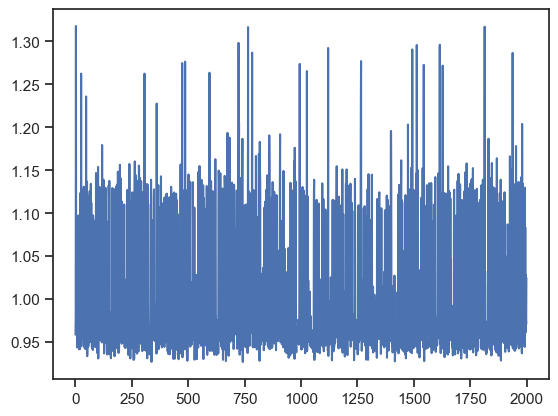

In [184]:
params = {
    'num_epoch' : 2000,
    'batch_size' : 10, # was 20 on 600 dataset
    'lr' : 1e-10,
    'weight_decay' : 0.0, # typically between 0 and 0.1 on logarithmic scale
    'sigma' : 7.0,
    'MMD_lambda' : 1e-4,
    'model_name' : 'WAE_v1',
} # for WAE training

dataset = FeatureDataset(raw_x[:], raw_y[:]) #numpy to tensor
dataloader = DataLoader(dataset, batch_size=params['batch_size'], shuffle=True) # tensor to dataloader

# %%train the WAE
model = WAE(raw_x.shape[1]).to(device) # initialize the model 
optimizer = Adam(model.parameters(), lr = params['lr'], weight_decay = params['weight_decay']) # optimizer

same_seeds(1) #seed equals to 1

loss_=train_WAE(model, optimizer, dataloader, params)
plt.figure()
sns.set_style('ticks')
plt.plot(range(len(loss_)),loss_)

In [185]:
loss_[-1]

1.0246706207593281

In [188]:
#%%Double check on the reconstructed features
#one way to find out whether WAE (or any other VAE) has learned the representation is 
# to compare the reconstructed and original compositions.if you are not happy with the 
# reconstruction. go back to the previous step and change the params.
#double check on the reconstructed compositions
t = time.localtime()
model_dir = os.path.join(root,'{}/{}_{}.pth'.format(params['model_name'], params['model_name'],params['num_epoch']))#load your model
model = WAE(raw_x.shape[1]).to(device)
model.load_state_dict(torch.load(model_dir))
model.eval()
with torch.no_grad():
    test = torch.FloatTensor(raw_x).to(device)
    recon_x, z = model(test)
    recon_x = model.decoder(z)
    recon_x = recon_x.cpu().detach().numpy()
# #%%Display image and label.
# train_features, train_labels = next(iter(dataloader))
# print(f"Feature batch shape: {train_features.size()}")
# print(f"Labels batch shape: {train_labels.size()}")


In [189]:
#m data set

#%%Visualize the WAE latent space
# Here we assign different colors to alloy with and without Copper, as we expected them to differ significantly in the latent space.
sns.set_style('ticks')
model = WAE(raw_x.shape[1]).to(device)
model.load_state_dict(torch.load(model_dir))
dataset = FeatureDataset(raw_x[:], raw_y[:])
latents = get_latents(model, dataset)

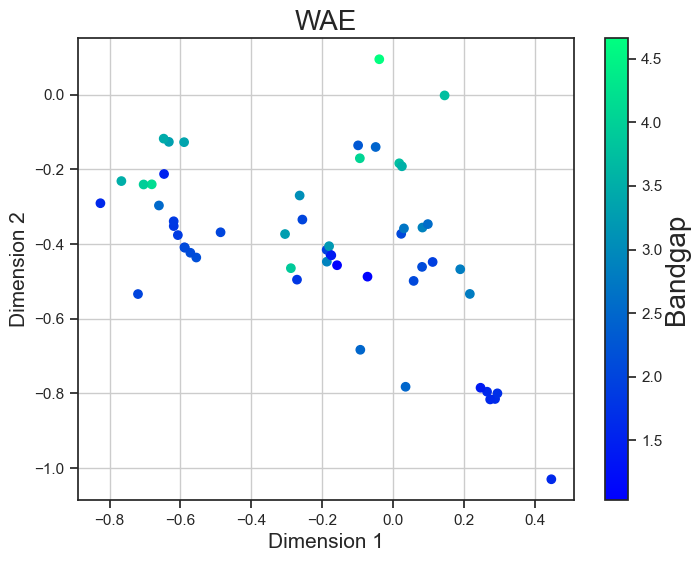

In [193]:
fig = plt.figure(figsize = (8,6))

marker_size=15
plt.scatter(latents[:,0], latents[:,1], c=Bandgap_54x[:],
            cmap=matplotlib.colormaps['winter'])
plt.title('WAE', fontsize = 20)
plt.xlabel('Dimension 1', fontsize = 15)
plt.ylabel('Dimension 2', fontsize = 15)
plt.grid()
cbar= plt.colorbar()
cbar.set_label("Bandgap", labelpad=+1, size=20)
plt.show()

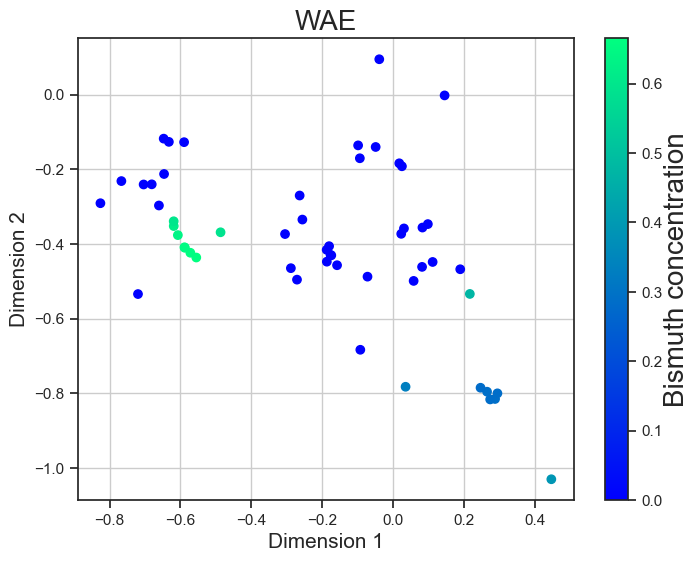

In [194]:
fig = plt.figure(figsize = (8,6))

marker_size=15
plt.scatter(latents[:,0], latents[:,1], c=master_database_wo_duplicates["Bi"],
            cmap=matplotlib.colormaps['winter'])
plt.title('WAE', fontsize = 20)
plt.xlabel('Dimension 1', fontsize = 15)
plt.ylabel('Dimension 2', fontsize = 15)
plt.grid()
cbar= plt.colorbar()
cbar.set_label("Bismuth concentration", labelpad=+1, size=20)
plt.show()

Legacy code:

In [195]:
# low_bi = weight_compositions_NaN["Bi"] <= 0
# low_bi_latent = latents[low_bi]
# low_bi_color = raw_y[:][low_bi]

# high_bi = weight_compositions_NaN["Bi"] > 0
# high_bi_latent = latents[high_bi]
# high_bi_color = raw_y[:][high_bi]

# fig, axs = plt.subplots(figsize = (3, 3),dpi=200)

# #axs.set_aspect(1.)
# #axs.set_ylim(-7,7)
# #axs.set_xlim(-11,5)

# #axs.set_yticks(np.arange(-6, 8, step=2))
# #axs.set_xticks(np.arange(-10, 5, step=2))

# #axs.set_yticklabels(np.arange(-6, 8, step=2), fontsize=7)
# #axs.set_xticklabels(np.arange(-10, 5, step=2), fontsize=7)

# for axis in ['top','bottom','left','right']:
#     axs.spines[axis].set_linewidth(1.)
    
# # axs.tick_params(axis='both', which='major', top=False, labeltop=False, direction='out', width=1., length=4)
# # axs.tick_params(axis='both', which='major', right=False, labelright=False, direction='out', width=1., length=4)

# # #scatter1 = axs.scatter(low_cu_latent[:,0], low_cu_latent[:,1], c=low_cu_color, alpha=.75, s=10, linewidths=0, cmap='viridis')
# # #scatter2 = axs.scatter(high_cu_latent[:,0], high_cu_latent[:,1], c=high_cu_color, alpha=.75, s=9, linewidths=0, cmap='Reds')

# scatter1 = axs.scatter(low_bi_latent[:,0], low_bi_latent[:,1], c='steelblue', alpha=.55, s=8, linewidths=0, label='Alloys w/o Bi')
# scatter2 = axs.scatter(high_bi_latent[:,0], high_bi_latent[:,1], c='firebrick', alpha=.65, s=14, linewidths=0, marker='^', label='Alloys w/ Bi')
# #scatter3 = axs.scatter(latents_exp_4[:,0], latents_exp_4[:,1], alpha=1., s=10, linewidths=.75, edgecolors='darkslategray', facecolors='w')#, label='New FeCoNiCr HEAs')
# #scatter4 = axs.scatter(latents_exp_5[:,0], latents_exp_5[:,1], alpha=1., s=16, linewidths=.75, edgecolors='darkred', facecolors='w',marker='^')#, label='New FeCoNiCrCu HEAs')

# handles,labels = axs.get_legend_handles_labels()
# handles = handles[::1]
# labels = labels[::1]

# legend_properties = {'size':7.5}
# axs.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.015,1.017), handletextpad=-0.3, frameon=False, prop=legend_properties)
# #axs.legend(handles, labels, loc='upper left', bbox_to_anchor=(-0.045,1.017), handletextpad=-0.3, frameon=False, prop=legend_properties)

# #rect = patches.Rectangle((-19.4,15.0), 18, 4.5, linewidth=0,edgecolor=None,facecolor='k', alpha=0.03,linestyle=None,zorder=-10) #(0.2,15.4), 14, 4.1
# #axs.add_patch(rect)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 54 but corresponding boolean dimension is 60

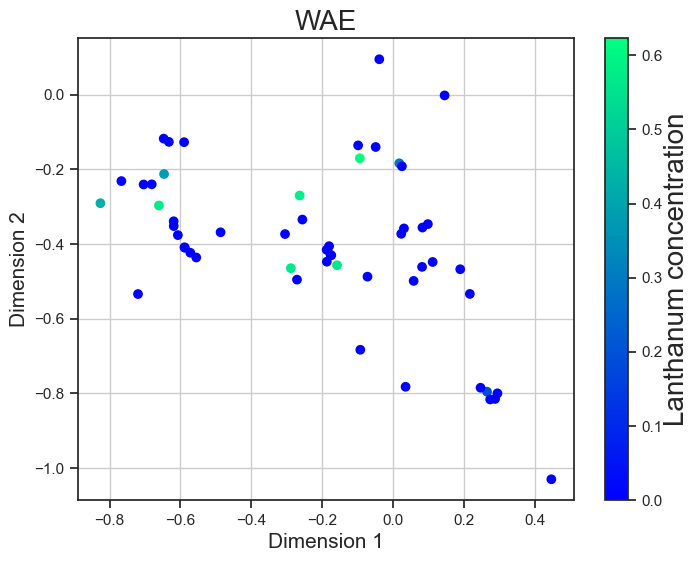

In [199]:
fig = plt.figure(figsize = (8,6))

marker_size=15
plt.scatter(latents[:,0], latents[:,1], c=master_database_wo_duplicates["La"],
            cmap=matplotlib.colormaps['winter'])
plt.title('WAE', fontsize = 20)
plt.xlabel('Dimension 1', fontsize = 15)
plt.ylabel('Dimension 2', fontsize = 15)
plt.grid()
cbar= plt.colorbar()
cbar.set_label("Lanthanum concentration", labelpad=+1, size=20)
plt.show()